In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/ESPECIALIADAD B.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 9 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=96.9, y1=127.3
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 153
Page 1, Q1, A: Yellow percentage: 0.0%


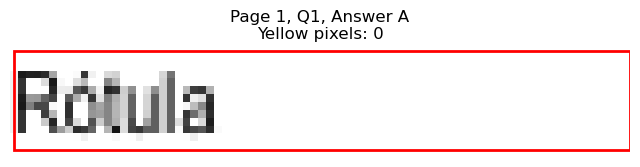

Page 1, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=109.0, y1=139.9
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 224
Page 1, Q1, B: Yellow percentage: 0.0%


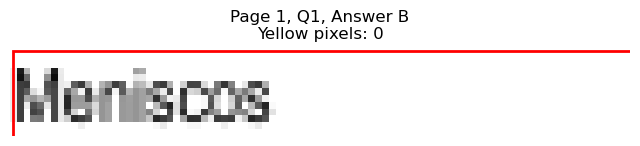

Page 1, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=402.3, y1=127.3
Page 1, Q1, C: Yellow pixels: 1249
Page 1, Q1, C: Total non-white pixels: 1764
Page 1, Q1, C: Yellow percentage: 70.8%


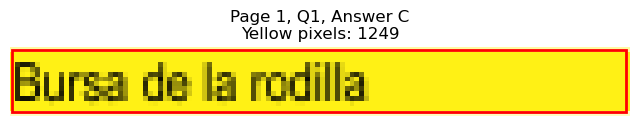

Page 1, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=406.7, y1=139.9
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 496
Page 1, Q1, D: Yellow percentage: 0.0%


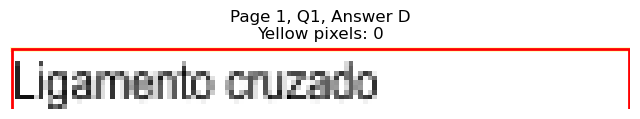


Page 1, Q1 - Selected Answer: C (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=160.1, y1=203.0
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 496
Page 1, Q2, A: Yellow percentage: 0.0%


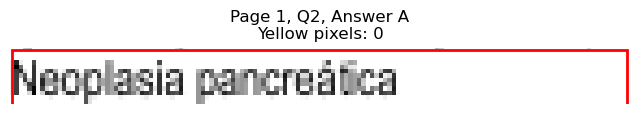

Page 1, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=213.3, y1=215.6
Page 1, Q2, B: Yellow pixels: 0
Page 1, Q2, B: Total non-white pixels: 722
Page 1, Q2, B: Yellow percentage: 0.0%


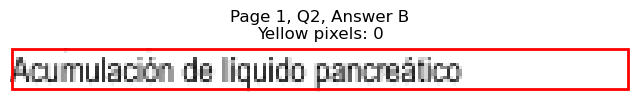

Page 1, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=448.4, y1=203.0
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 775
Page 1, Q2, C: Yellow percentage: 0.0%


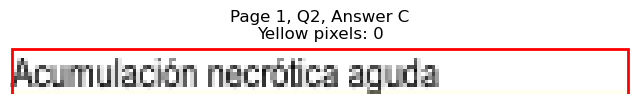

Page 1, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=429.4, y1=215.6
Page 1, Q2, D: Yellow pixels: 1592
Page 1, Q2, D: Total non-white pixels: 2142
Page 1, Q2, D: Yellow percentage: 74.3%


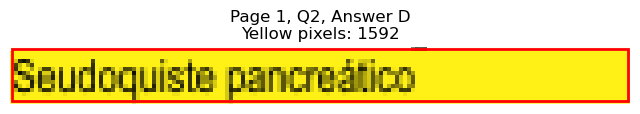


Page 1, Q2 - Selected Answer: D (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=115.0, y1=266.1
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 216
Page 1, Q3, A: Yellow percentage: 0.0%


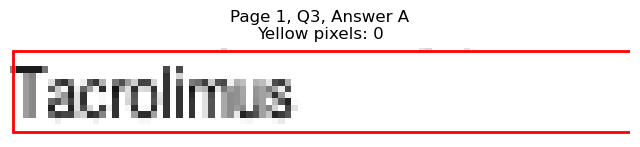

Page 1, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=103.0, y1=278.7
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 156
Page 1, Q3, B: Yellow percentage: 0.0%


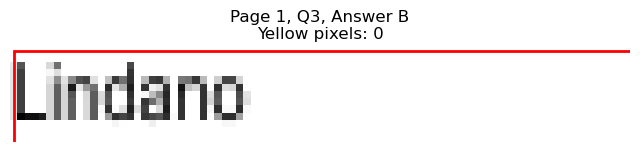

Page 1, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=399.3, y1=266.1
Page 1, Q3, C: Yellow pixels: 1340
Page 1, Q3, C: Total non-white pixels: 1722
Page 1, Q3, C: Yellow percentage: 77.8%


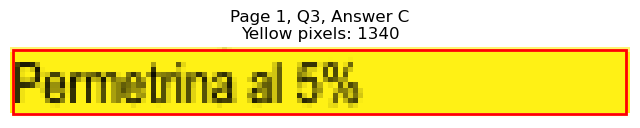

Page 1, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=407.3, y1=278.7
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 522
Page 1, Q3, D: Yellow percentage: 0.0%


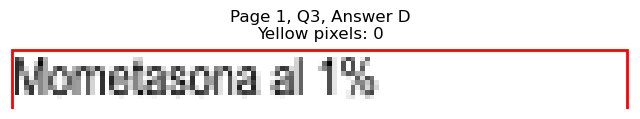


Page 1, Q3 - Selected Answer: C (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=88.3, y1=329.3
Page 1, Q4, A: Yellow pixels: 773
Page 1, Q4, A: Total non-white pixels: 994
Page 1, Q4, A: Yellow percentage: 77.8%


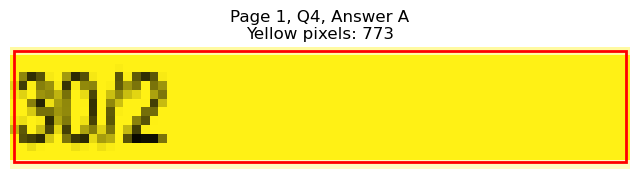

Page 1, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=88.3, y1=341.9
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 159
Page 1, Q4, B: Yellow percentage: 0.0%


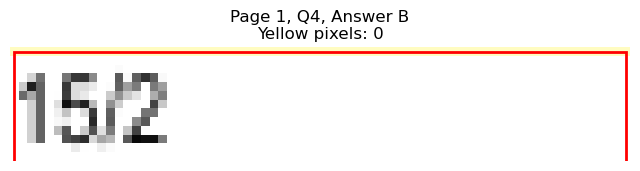

Page 1, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=347.6, y1=329.3
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 90
Page 1, Q4, C: Yellow percentage: 0.0%


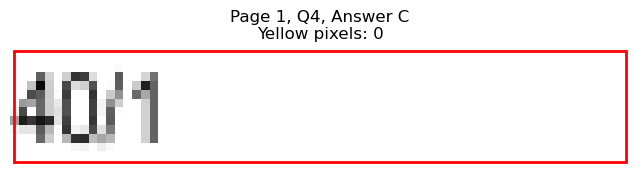

Page 1, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=347.6, y1=341.9
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 99
Page 1, Q4, D: Yellow percentage: 0.0%


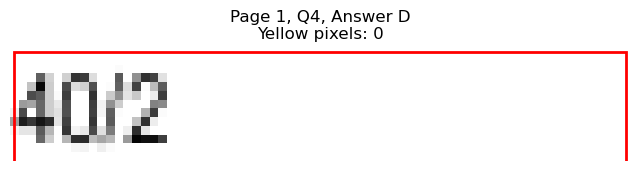


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=392.3, x1=150.0, y1=405.0
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 515
Page 1, Q5, A: Yellow percentage: 0.0%


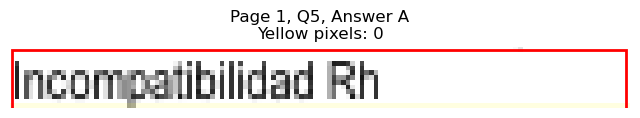

Page 1, Q5 - B: Detected box: x0=68.3, y0=404.9, x1=150.6, y1=417.6
Page 1, Q5, B: Yellow pixels: 1426
Page 1, Q5, B: Total non-white pixels: 1862
Page 1, Q5, B: Yellow percentage: 76.6%


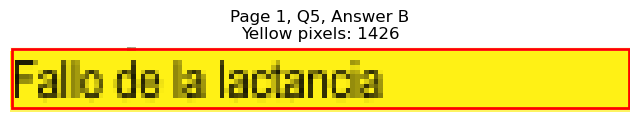

Page 1, Q5 - C: Detected box: x0=327.5, y0=392.3, x1=395.2, y1=405.0
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 373
Page 1, Q5, C: Yellow percentage: 0.0%


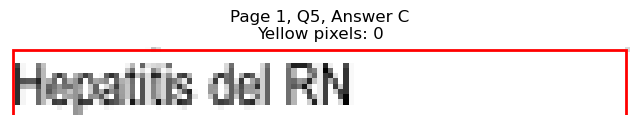

Page 1, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=398.7, y1=417.6
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 357
Page 1, Q5, D: Yellow percentage: 0.0%


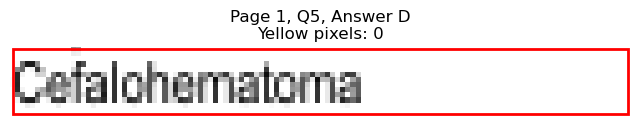


Page 1, Q5 - Selected Answer: B (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=480.8, x1=160.6, y1=493.4
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 471
Page 1, Q6, A: Yellow percentage: 0.0%


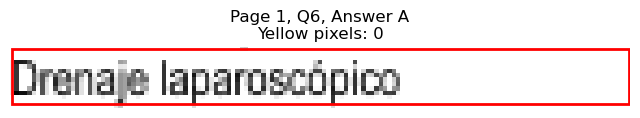

Page 1, Q6 - B: Detected box: x0=68.3, y0=493.4, x1=135.5, y1=506.0
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 350
Page 1, Q6, B: Yellow percentage: 0.0%


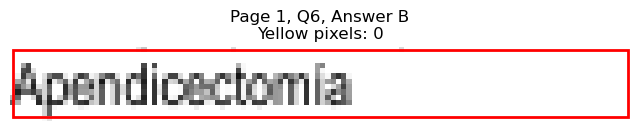

Page 1, Q6 - C: Detected box: x0=327.5, y0=480.8, x1=409.3, y1=493.4
Page 1, Q6, C: Yellow pixels: 133
Page 1, Q6, C: Total non-white pixels: 553
Page 1, Q6, C: Yellow percentage: 24.1%


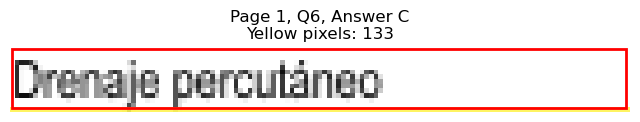

Page 1, Q6 - D: Detected box: x0=327.5, y0=493.4, x1=399.3, y1=506.0
Page 1, Q6, D: Yellow pixels: 1301
Page 1, Q6, D: Total non-white pixels: 1600
Page 1, Q6, D: Yellow percentage: 81.3%


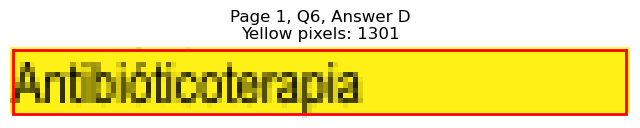


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=581.7, x1=116.4, y1=594.4
Page 1, Q7, A: Yellow pixels: 996
Page 1, Q7, A: Total non-white pixels: 1386
Page 1, Q7, A: Yellow percentage: 71.9%


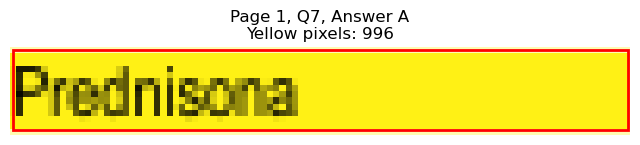

Page 1, Q7 - B: Detected box: x0=68.3, y0=594.3, x1=133.0, y1=607.0
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 440
Page 1, Q7, B: Yellow percentage: 0.0%


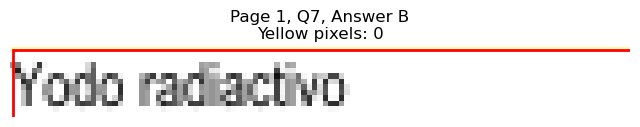

Page 1, Q7 - C: Detected box: x0=327.5, y0=581.7, x1=371.2, y1=594.4
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 222
Page 1, Q7, C: Yellow percentage: 0.0%


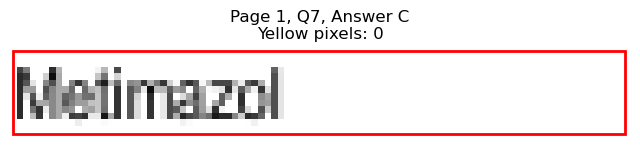

Page 1, Q7 - D: Detected box: x0=327.5, y0=594.3, x1=373.1, y1=607.0
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 225
Page 1, Q7, D: Yellow percentage: 0.0%


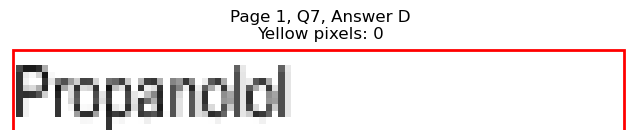


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=657.5, x1=163.6, y1=670.1
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 497
Page 1, Q8, A: Yellow percentage: 0.0%


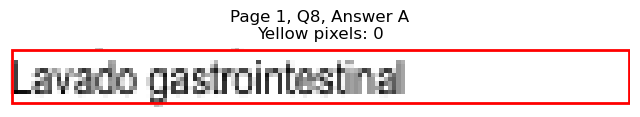

Page 1, Q8 - B: Detected box: x0=68.3, y0=670.1, x1=121.5, y1=682.7
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 278
Page 1, Q8, B: Yellow percentage: 0.0%


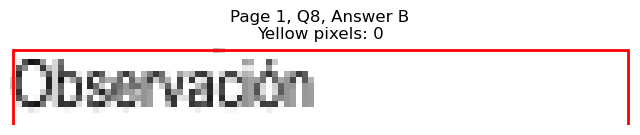

Page 1, Q8 - C: Detected box: x0=327.5, y0=657.5, x1=415.9, y1=670.1
Page 1, Q8, C: Yellow pixels: 139
Page 1, Q8, C: Total non-white pixels: 590
Page 1, Q8, C: Yellow percentage: 23.6%


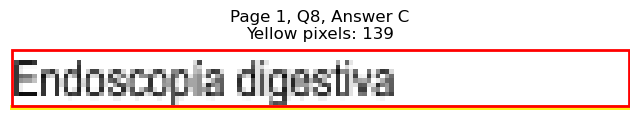

Page 1, Q8 - D: Detected box: x0=327.5, y0=670.1, x1=426.9, y1=682.7
Page 1, Q8, D: Yellow pixels: 1552
Page 1, Q8, D: Total non-white pixels: 1950
Page 1, Q8, D: Yellow percentage: 79.6%


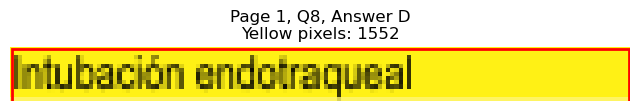


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=733.2, x1=198.6, y1=745.8
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 643
Page 1, Q9, A: Yellow percentage: 0.0%


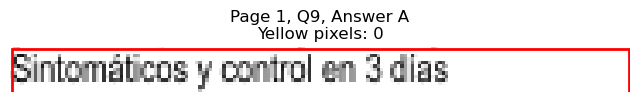

Page 1, Q9 - B: Detected box: x0=68.3, y0=745.8, x1=188.7, y1=758.4
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 593
Page 1, Q9, B: Yellow percentage: 0.0%


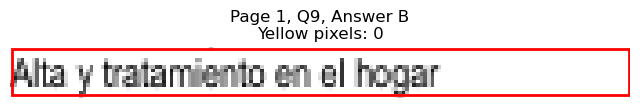

Page 1, Q9 - C: Detected box: x0=327.5, y0=733.2, x1=523.7, y1=745.8
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 1238
Page 1, Q9, C: Yellow percentage: 0.0%


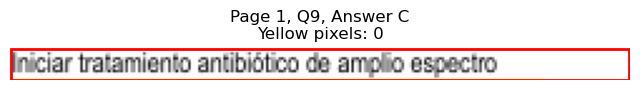

Page 1, Q9 - D: Detected box: x0=327.5, y0=745.8, x1=534.6, y1=758.4
Page 1, Q9, D: Yellow pixels: 1936
Page 1, Q9, D: Total non-white pixels: 2996
Page 1, Q9, D: Yellow percentage: 64.6%


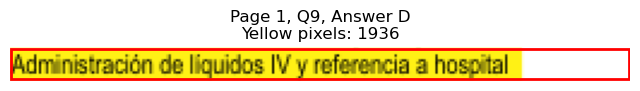


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=118.9, y1=127.3
Page 2, Q1, A: Yellow pixels: 101
Page 2, Q1, A: Total non-white pixels: 355
Page 2, Q1, A: Yellow percentage: 28.5%


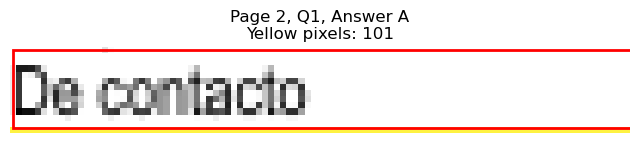

Page 2, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=114.0, y1=139.9
Page 2, Q1, B: Yellow pixels: 1089
Page 2, Q1, B: Total non-white pixels: 1261
Page 2, Q1, B: Yellow percentage: 86.4%


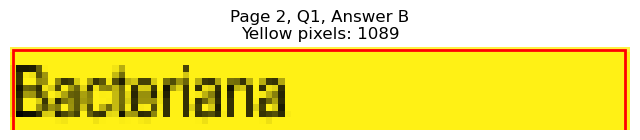

Page 2, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=374.2, y1=127.3
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 237
Page 2, Q1, C: Yellow percentage: 0.0%


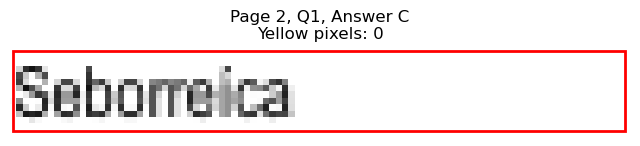

Page 2, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=381.7, y1=139.9
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 301
Page 2, Q1, D: Yellow percentage: 0.0%


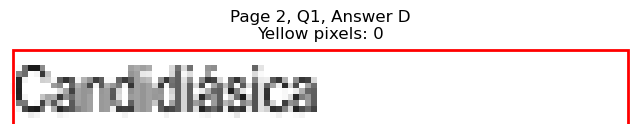


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=77.3, y1=177.8
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 38
Page 2, Q2, A: Yellow percentage: 0.0%


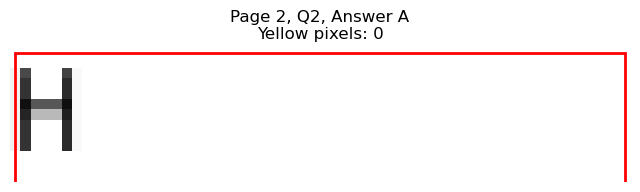

Page 2, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=101.4, y1=190.4
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 183
Page 2, Q2, B: Yellow percentage: 0.0%


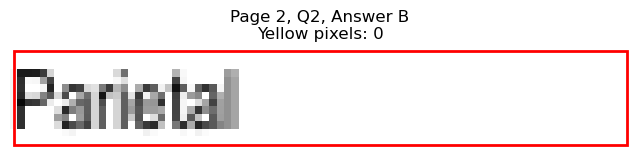

Page 2, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=364.6, y1=177.8
Page 2, Q2, C: Yellow pixels: 1002
Page 2, Q2, C: Total non-white pixels: 1144
Page 2, Q2, C: Yellow percentage: 87.6%


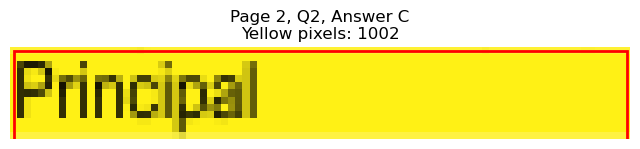

Page 2, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=337.1, y1=190.4
Page 2, Q2, D: Yellow pixels: 61
Page 2, Q2, D: Total non-white pixels: 96
Page 2, Q2, D: Yellow percentage: 63.5%


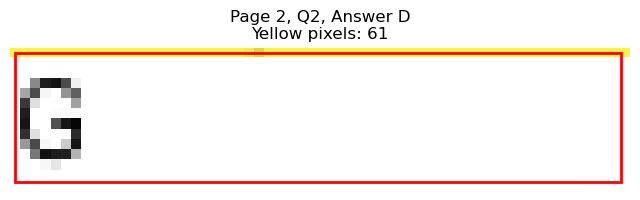


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=118.9, y1=278.7
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 254
Page 2, Q3, A: Yellow percentage: 0.0%


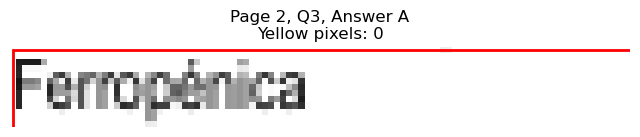

Page 2, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=104.9, y1=291.5
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 202
Page 2, Q3, B: Yellow percentage: 0.0%


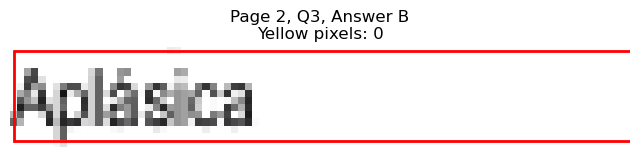

Page 2, Q3 - C: Detected box: x0=327.5, y0=266.1, x1=372.7, y1=278.7
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 225
Page 2, Q3, C: Yellow percentage: 0.0%


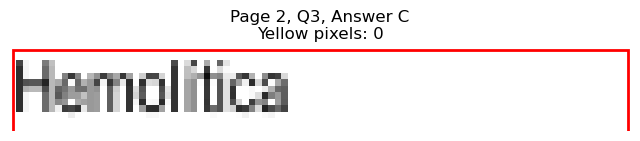

Page 2, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=390.2, y1=291.5
Page 2, Q3, D: Yellow pixels: 1183
Page 2, Q3, D: Total non-white pixels: 1596
Page 2, Q3, D: Yellow percentage: 74.1%


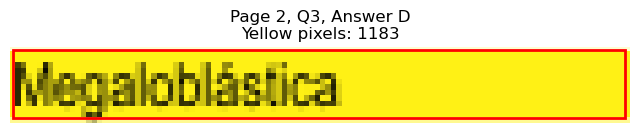


Page 2, Q3 - Selected Answer: D (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=354.5, x1=172.1, y1=367.2
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 555
Page 2, Q4, A: Yellow percentage: 0.0%


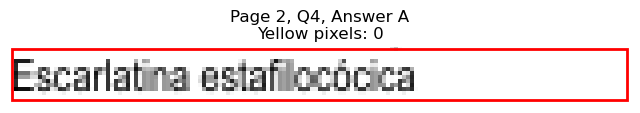

Page 2, Q4 - B: Detected box: x0=68.3, y0=367.1, x1=173.7, y1=379.8
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 529
Page 2, Q4, B: Yellow percentage: 0.0%


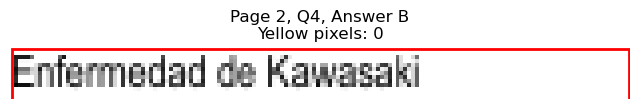

Page 2, Q4 - C: Detected box: x0=327.5, y0=354.5, x1=432.9, y1=367.2
Page 2, Q4, C: Yellow pixels: 156
Page 2, Q4, C: Total non-white pixels: 700
Page 2, Q4, C: Yellow percentage: 22.3%


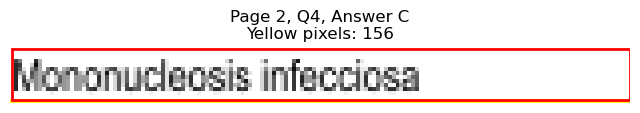

Page 2, Q4 - D: Detected box: x0=327.5, y0=367.1, x1=435.4, y1=379.8
Page 2, Q4, D: Yellow pixels: 1630
Page 2, Q4, D: Total non-white pixels: 2067
Page 2, Q4, D: Yellow percentage: 78.9%


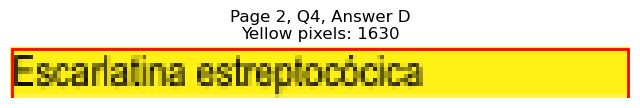


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=56.6, y0=417.6, x1=65.2, y1=430.3
Page 2, Q5, A: Yellow pixels: 60
Page 2, Q5, A: Total non-white pixels: 105
Page 2, Q5, A: Yellow percentage: 57.1%


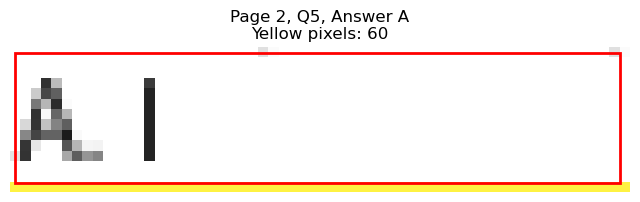

Page 2, Q5 - B: Detected box: x0=68.3, y0=430.2, x1=78.4, y1=442.9
Page 2, Q5, B: Yellow pixels: 761
Page 2, Q5, B: Total non-white pixels: 793
Page 2, Q5, B: Yellow percentage: 96.0%


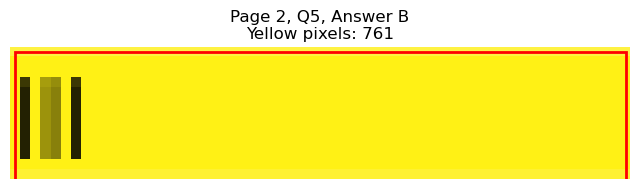

Page 2, Q5 - C: Detected box: x0=327.5, y0=417.6, x1=338.6, y1=430.3
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 43
Page 2, Q5, C: Yellow percentage: 0.0%


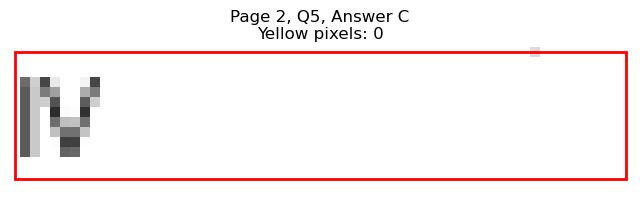

Page 2, Q5 - D: Detected box: x0=315.4, y0=430.2, x1=324.4, y1=442.9
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 72
Page 2, Q5, D: Yellow percentage: 0.0%


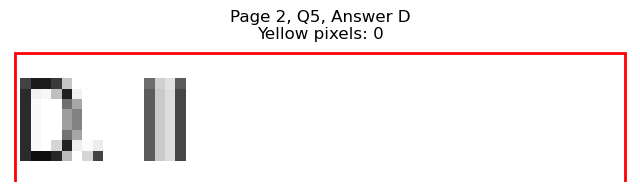


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=480.8, x1=113.4, y1=493.4
Page 2, Q6, A: Yellow pixels: 952
Page 2, Q6, A: Total non-white pixels: 1344
Page 2, Q6, A: Yellow percentage: 70.8%


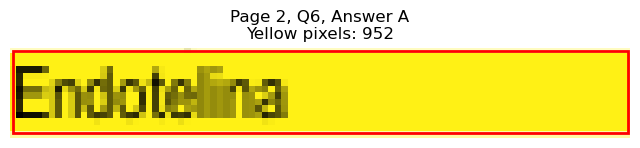

Page 2, Q6 - B: Detected box: x0=68.3, y0=493.4, x1=121.5, y1=506.0
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 355
Page 2, Q6, B: Yellow percentage: 0.0%


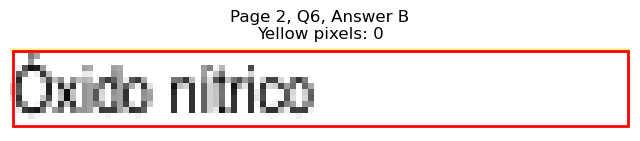

Page 2, Q6 - C: Detected box: x0=327.5, y0=480.8, x1=378.2, y1=493.4
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 245
Page 2, Q6, C: Yellow percentage: 0.0%


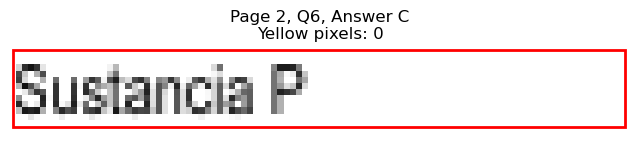

Page 2, Q6 - D: Detected box: x0=327.5, y0=493.4, x1=370.1, y1=506.0
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 232
Page 2, Q6, D: Yellow percentage: 0.0%


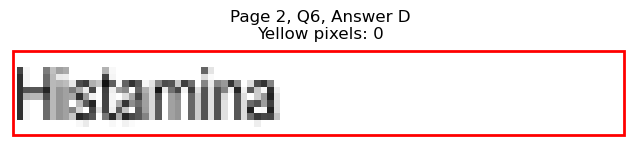


Page 2, Q6 - Selected Answer: A (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=543.8, x1=154.1, y1=556.4
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 443
Page 2, Q7, A: Yellow percentage: 0.0%


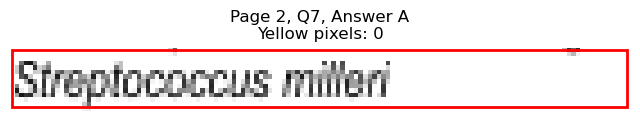

Page 2, Q7 - B: Detected box: x0=68.3, y0=556.5, x1=167.1, y1=569.2
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 507
Page 2, Q7, B: Yellow percentage: 0.0%


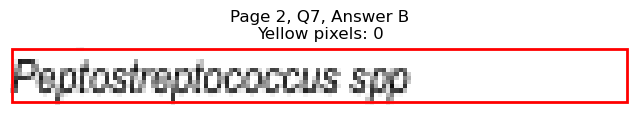

Page 2, Q7 - C: Detected box: x0=327.5, y0=543.8, x1=394.7, y1=556.4
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 368
Page 2, Q7, C: Yellow percentage: 0.0%


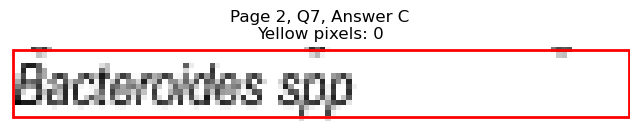

Page 2, Q7 - D: Detected box: x0=327.5, y0=556.5, x1=423.3, y1=569.2
Page 2, Q7, D: Yellow pixels: 1545
Page 2, Q7, D: Total non-white pixels: 2058
Page 2, Q7, D: Yellow percentage: 75.1%


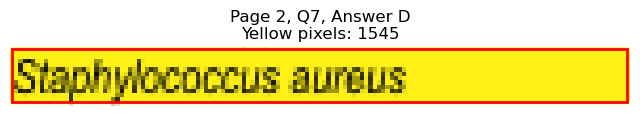


Page 2, Q7 - Selected Answer: D (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=632.2, x1=110.4, y1=644.9
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 198
Page 2, Q8, A: Yellow percentage: 0.0%


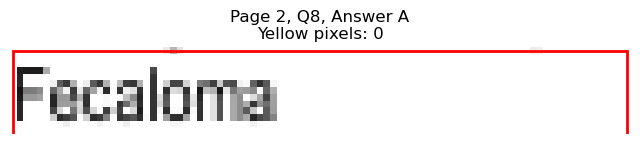

Page 2, Q8 - B: Detected box: x0=68.3, y0=644.9, x1=156.0, y1=657.5
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 443
Page 2, Q8, B: Yellow percentage: 0.0%


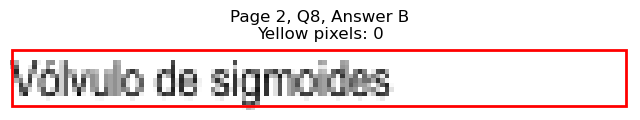

Page 2, Q8 - C: Detected box: x0=327.5, y0=632.2, x1=441.9, y1=644.9
Page 2, Q8, C: Yellow pixels: 1713
Page 2, Q8, C: Total non-white pixels: 2145
Page 2, Q8, C: Yellow percentage: 79.9%


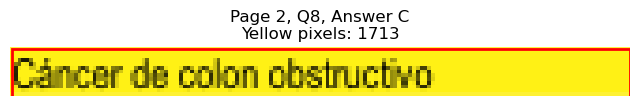

Page 2, Q8 - D: Detected box: x0=327.5, y0=644.9, x1=418.9, y1=657.5
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 483
Page 2, Q8, D: Yellow percentage: 0.0%


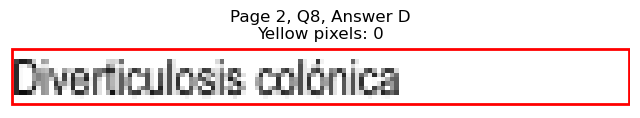


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=695.4, x1=105.4, y1=708.0
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 178
Page 2, Q9, A: Yellow percentage: 0.0%


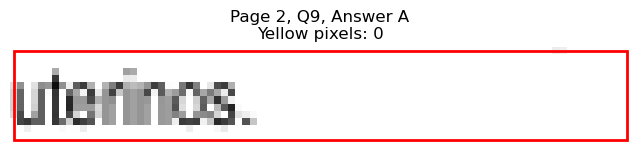

Page 2, Q9 - B: Detected box: x0=68.3, y0=708.0, x1=113.4, y1=720.6
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 215
Page 2, Q9, B: Yellow percentage: 0.0%


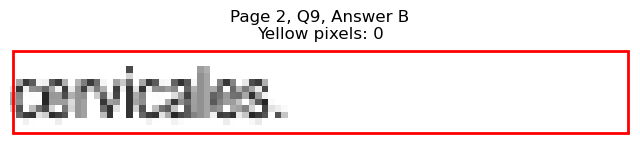

Page 2, Q9 - C: Detected box: x0=327.5, y0=695.4, x1=366.2, y1=708.0
Page 2, Q9, C: Yellow pixels: 1029
Page 2, Q9, C: Total non-white pixels: 1170
Page 2, Q9, C: Yellow percentage: 87.9%


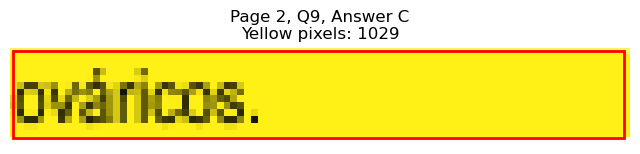

Page 2, Q9 - D: Detected box: x0=327.5, y0=708.0, x1=367.2, y1=720.6
Page 2, Q9, D: Yellow pixels: 91
Page 2, Q9, D: Total non-white pixels: 305
Page 2, Q9, D: Yellow percentage: 29.8%


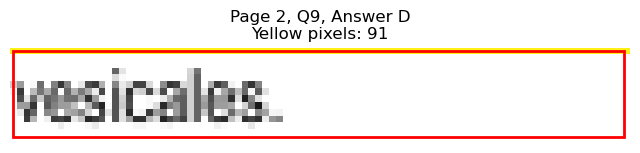


Page 2, Q9 - Selected Answer: C (based on yellow pixel count)





Page 3: Found 9 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=138.5, y1=114.7
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 371
Page 3, Q1, A: Yellow percentage: 0.0%


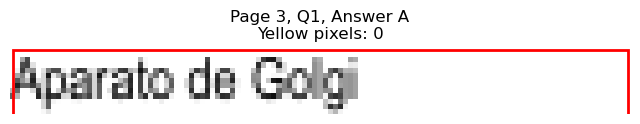

Page 3, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=115.9, y1=127.3
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 254
Page 3, Q1, B: Yellow percentage: 0.0%


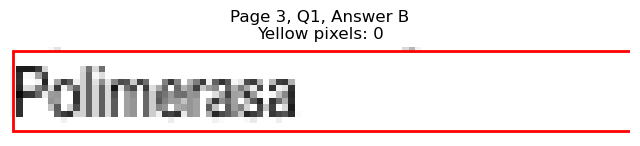

Page 3, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=380.2, y1=114.7
Page 3, Q1, C: Yellow pixels: 1143
Page 3, Q1, C: Total non-white pixels: 1352
Page 3, Q1, C: Yellow percentage: 84.5%


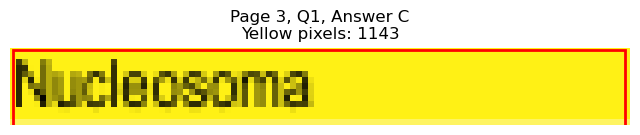

Page 3, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=378.2, y1=127.3
Page 3, Q1, D: Yellow pixels: 102
Page 3, Q1, D: Total non-white pixels: 342
Page 3, Q1, D: Yellow percentage: 29.8%


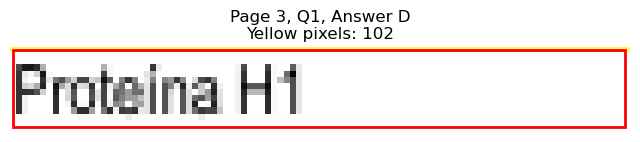


Page 3, Q1 - Selected Answer: C (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=172.1, y1=190.4
Page 3, Q2, A: Yellow pixels: 155
Page 3, Q2, A: Total non-white pixels: 615
Page 3, Q2, A: Yellow percentage: 25.2%


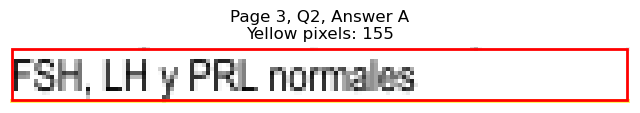

Page 3, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=182.7, y1=203.0
Page 3, Q2, B: Yellow pixels: 1760
Page 3, Q2, B: Total non-white pixels: 2145
Page 3, Q2, B: Yellow percentage: 82.1%


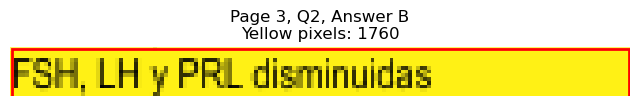

Page 3, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=430.4, y1=190.4
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 473
Page 3, Q2, C: Yellow percentage: 0.0%


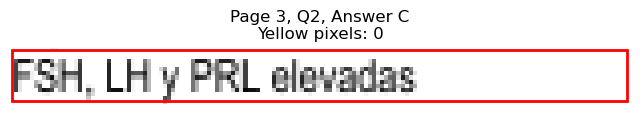

Page 3, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=489.6, y1=203.0
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 782
Page 3, Q2, D: Yellow percentage: 0.0%


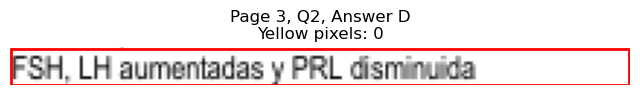


Page 3, Q2 - Selected Answer: B (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=122.4, y1=266.1
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 283
Page 3, Q3, A: Yellow percentage: 0.0%


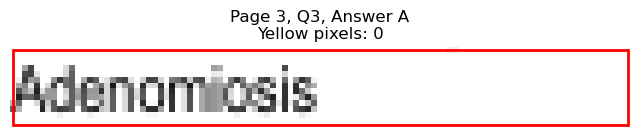

Page 3, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=165.6, y1=278.7
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 529
Page 3, Q3, B: Yellow percentage: 0.0%


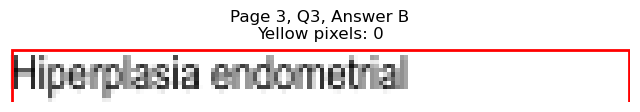

Page 3, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=404.8, y1=266.1
Page 3, Q3, C: Yellow pixels: 128
Page 3, Q3, C: Total non-white pixels: 524
Page 3, Q3, C: Yellow percentage: 24.4%


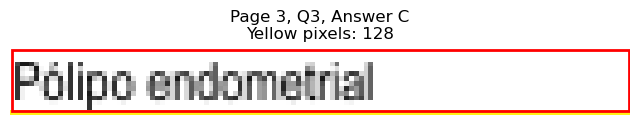

Page 3, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=449.5, y1=278.7
Page 3, Q3, D: Yellow pixels: 1761
Page 3, Q3, D: Total non-white pixels: 2249
Page 3, Q3, D: Yellow percentage: 78.3%


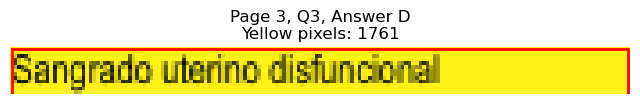


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=152.5, y1=329.3
Page 3, Q4, A: Yellow pixels: 1296
Page 3, Q4, A: Total non-white pixels: 1890
Page 3, Q4, A: Yellow percentage: 68.6%


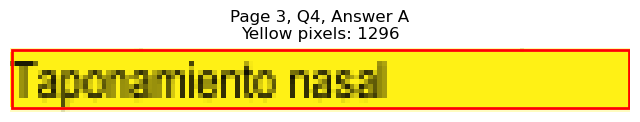

Page 3, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=121.0, y1=341.9
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 370
Page 3, Q4, B: Yellow percentage: 0.0%


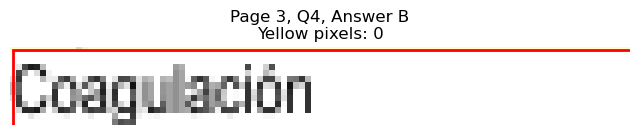

Page 3, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=373.7, y1=329.3
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 223
Page 3, Q4, C: Yellow percentage: 0.0%


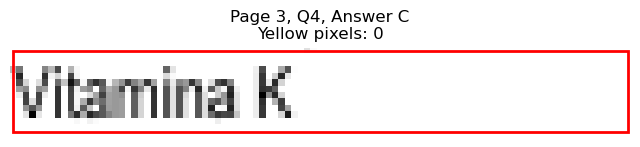

Page 3, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=385.3, y1=341.9
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 304
Page 3, Q4, D: Yellow percentage: 0.0%


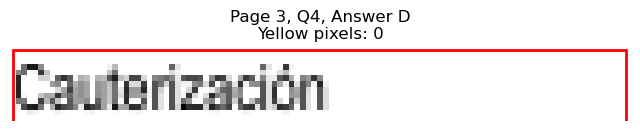


Page 3, Q4 - Selected Answer: A (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=392.3, x1=130.5, y1=405.0
Page 3, Q5, A: Yellow pixels: 1193
Page 3, Q5, A: Total non-white pixels: 1469
Page 3, Q5, A: Yellow percentage: 81.2%


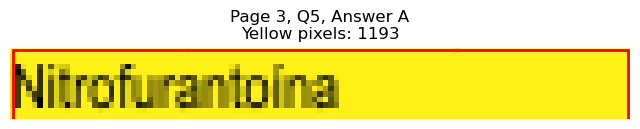

Page 3, Q5 - B: Detected box: x0=68.3, y0=404.9, x1=116.9, y1=417.6
Page 3, Q5, B: Yellow pixels: 99
Page 3, Q5, B: Total non-white pixels: 340
Page 3, Q5, B: Yellow percentage: 29.1%


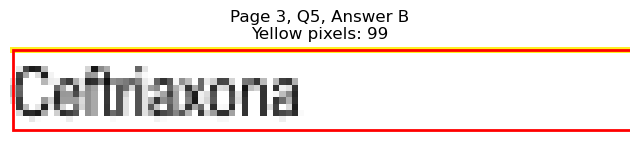

Page 3, Q5 - C: Detected box: x0=327.5, y0=392.3, x1=368.7, y1=405.0
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 212
Page 3, Q5, C: Yellow percentage: 0.0%


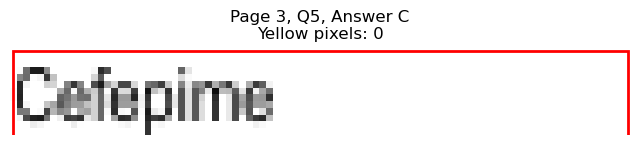

Page 3, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=375.7, y1=417.6
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 255
Page 3, Q5, D: Yellow percentage: 0.0%


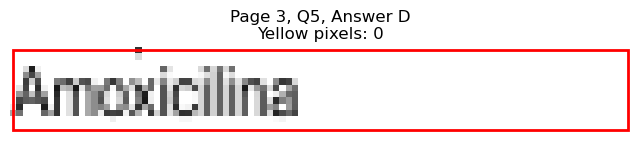


Page 3, Q5 - Selected Answer: A (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=480.8, x1=136.0, y1=493.4
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 341
Page 3, Q6, A: Yellow percentage: 0.0%


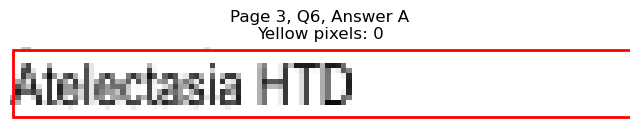

Page 3, Q6 - B: Detected box: x0=68.3, y0=493.4, x1=135.5, y1=506.0
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 346
Page 3, Q6, B: Yellow percentage: 0.0%


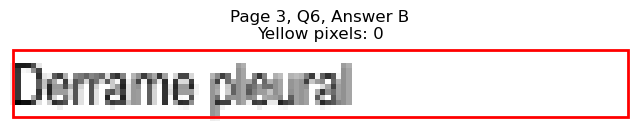

Page 3, Q6 - C: Detected box: x0=327.5, y0=480.8, x1=391.3, y1=493.4
Page 3, Q6, C: Yellow pixels: 115
Page 3, Q6, C: Total non-white pixels: 445
Page 3, Q6, C: Yellow percentage: 25.8%


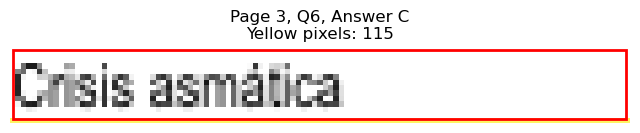

Page 3, Q6 - D: Detected box: x0=327.5, y0=493.4, x1=440.3, y1=506.0
Page 3, Q6, D: Yellow pixels: 1687
Page 3, Q6, D: Total non-white pixels: 2132
Page 3, Q6, D: Yellow percentage: 79.1%


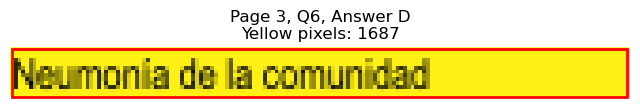


Page 3, Q6 - Selected Answer: D (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=556.5, x1=222.8, y1=569.2
Page 3, Q7, A: Yellow pixels: 2058
Page 3, Q7, A: Total non-white pixels: 2870
Page 3, Q7, A: Yellow percentage: 71.7%


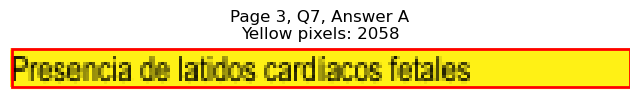

Page 3, Q7 - B: Detected box: x0=68.3, y0=569.1, x1=236.8, y1=581.8
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 1041
Page 3, Q7, B: Yellow percentage: 0.0%


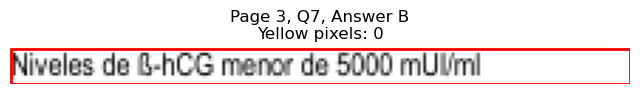

Page 3, Q7 - C: Detected box: x0=327.5, y0=556.5, x1=461.5, y1=569.2
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 634
Page 3, Q7, C: Yellow percentage: 0.0%


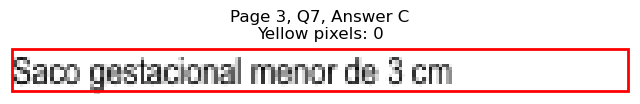

Page 3, Q7 - D: Detected box: x0=327.5, y0=569.1, x1=430.9, y1=581.8
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 532
Page 3, Q7, D: Yellow percentage: 0.0%


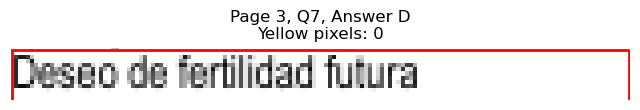


Page 3, Q7 - Selected Answer: A (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=632.2, x1=91.8, y1=644.9
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 114
Page 3, Q8, A: Yellow percentage: 0.0%


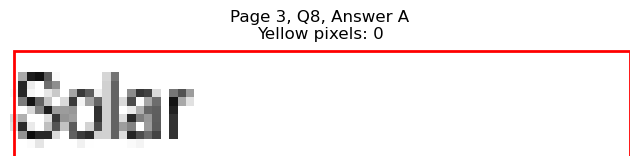

Page 3, Q8 - B: Detected box: x0=68.3, y0=644.9, x1=109.0, y1=657.5
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 207
Page 3, Q8, B: Yellow percentage: 0.0%


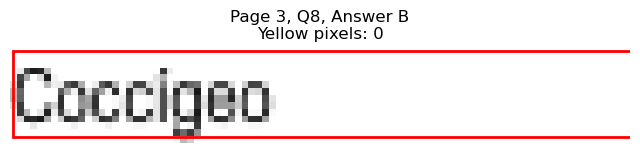

Page 3, Q8 - C: Detected box: x0=327.5, y0=632.2, x1=353.6, y1=644.9
Page 3, Q8, C: Yellow pixels: 907
Page 3, Q8, C: Total non-white pixels: 1001
Page 3, Q8, C: Yellow percentage: 90.6%


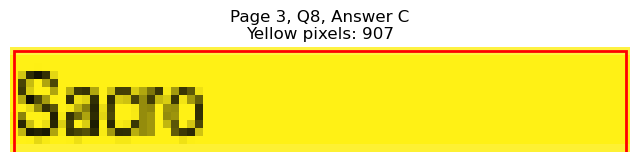

Page 3, Q8 - D: Detected box: x0=327.5, y0=644.9, x1=360.7, y1=657.5
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 137
Page 3, Q8, D: Yellow percentage: 0.0%


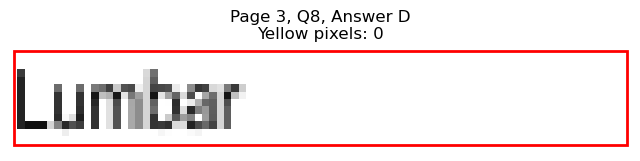


Page 3, Q8 - Selected Answer: C (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=695.4, x1=148.6, y1=708.0
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 371
Page 3, Q9, A: Yellow percentage: 0.0%


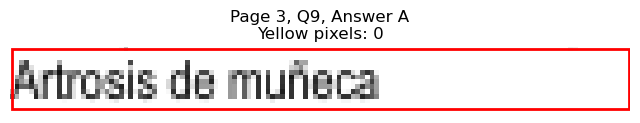

Page 3, Q9 - B: Detected box: x0=68.3, y0=708.0, x1=144.0, y1=720.6
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 375
Page 3, Q9, B: Yellow percentage: 0.0%


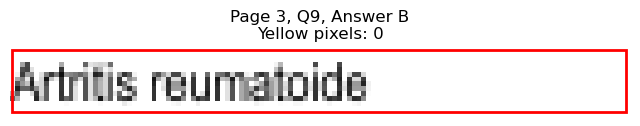

Page 3, Q9 - C: Detected box: x0=327.5, y0=695.4, x1=442.9, y1=708.0
Page 3, Q9, C: Yellow pixels: 166
Page 3, Q9, C: Total non-white pixels: 913
Page 3, Q9, C: Yellow percentage: 18.2%


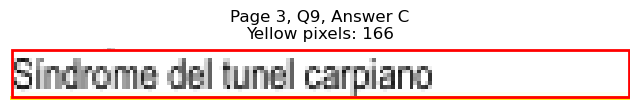

Page 3, Q9 - D: Detected box: x0=327.5, y0=708.0, x1=431.8, y1=720.6
Page 3, Q9, D: Yellow pixels: 1624
Page 3, Q9, D: Total non-white pixels: 2170
Page 3, Q9, D: Yellow percentage: 74.8%


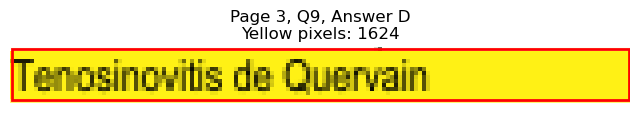


Page 3, Q9 - Selected Answer: D (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=110.9, y1=127.3
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 222
Page 4, Q1, A: Yellow percentage: 0.0%


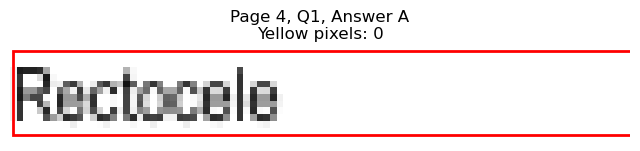

Page 4, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=154.1, y1=139.9
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 451
Page 4, Q1, B: Yellow percentage: 0.0%


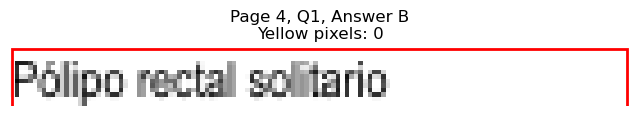

Page 4, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=424.4, y1=127.3
Page 4, Q1, C: Yellow pixels: 148
Page 4, Q1, C: Total non-white pixels: 612
Page 4, Q1, C: Yellow percentage: 24.2%


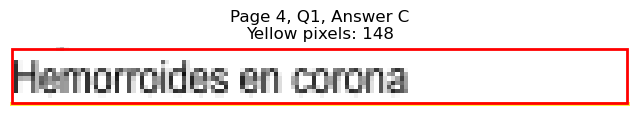

Page 4, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=390.2, y1=139.9
Page 4, Q1, D: Yellow pixels: 1262
Page 4, Q1, D: Total non-white pixels: 1482
Page 4, Q1, D: Yellow percentage: 85.2%


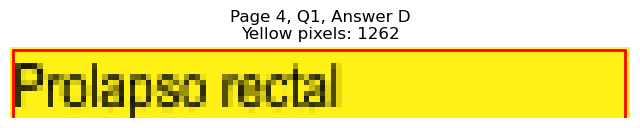


Page 4, Q1 - Selected Answer: D (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=110.9, y1=203.0
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 319
Page 4, Q2, A: Yellow percentage: 0.0%


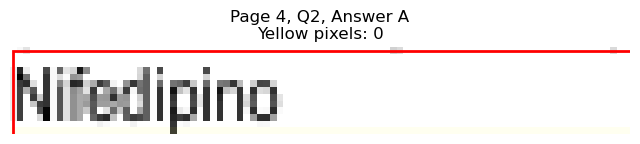

Page 4, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=158.5, y1=215.6
Page 4, Q2, B: Yellow pixels: 1469
Page 4, Q2, B: Total non-white pixels: 1974
Page 4, Q2, B: Yellow percentage: 74.4%


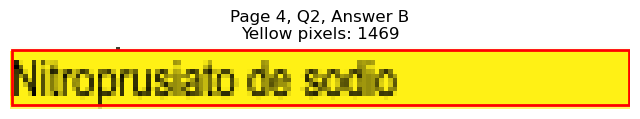

Page 4, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=366.7, y1=203.0
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 194
Page 4, Q2, C: Yellow percentage: 0.0%


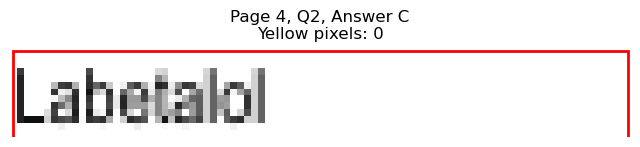

Page 4, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=382.7, y1=215.6
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 305
Page 4, Q2, D: Yellow percentage: 0.0%


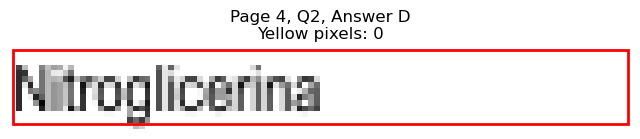


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=268.4, y1=278.7
Page 4, Q3, A: Yellow pixels: 2003
Page 4, Q3, A: Total non-white pixels: 2800
Page 4, Q3, A: Yellow percentage: 71.5%


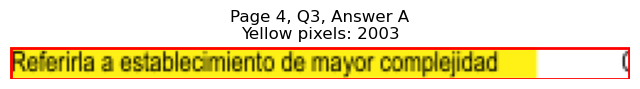

Page 4, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=162.1, y1=291.5
Page 4, Q3, B: Yellow pixels: 144
Page 4, Q3, B: Total non-white pixels: 583
Page 4, Q3, B: Yellow percentage: 24.7%


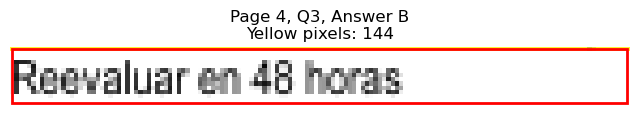

Page 4, Q3 - C: Detected box: x0=327.5, y0=266.1, x1=428.8, y1=278.7
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 541
Page 4, Q3, C: Yellow percentage: 0.0%


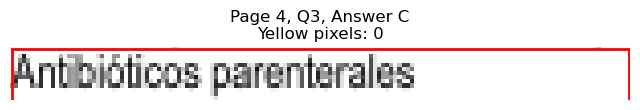

Page 4, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=494.6, y1=291.5
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 834
Page 4, Q3, D: Yellow percentage: 0.0%


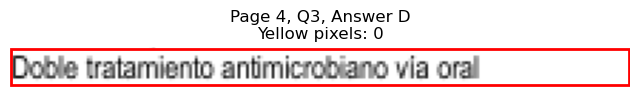


Page 4, Q3 - Selected Answer: A (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=341.9, x1=168.6, y1=354.6
Page 4, Q4, A: Yellow pixels: 151
Page 4, Q4, A: Total non-white pixels: 615
Page 4, Q4, A: Yellow percentage: 24.6%


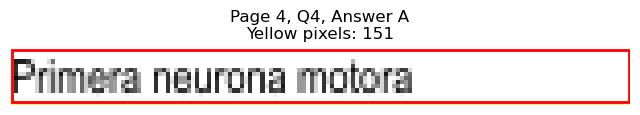

Page 4, Q4 - B: Detected box: x0=68.3, y0=354.5, x1=173.2, y1=367.2
Page 4, Q4, B: Yellow pixels: 1615
Page 4, Q4, B: Total non-white pixels: 2184
Page 4, Q4, B: Yellow percentage: 73.9%


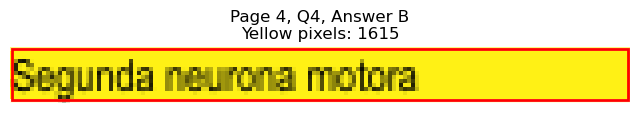

Page 4, Q4 - C: Detected box: x0=327.5, y0=341.9, x1=427.9, y1=354.6
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 498
Page 4, Q4, C: Yellow percentage: 0.0%


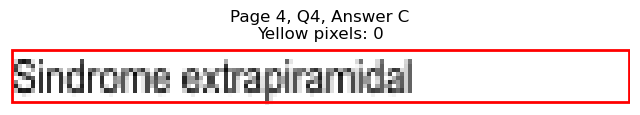

Page 4, Q4 - D: Detected box: x0=327.5, y0=354.5, x1=379.1, y1=367.2
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 276
Page 4, Q4, D: Yellow percentage: 0.0%


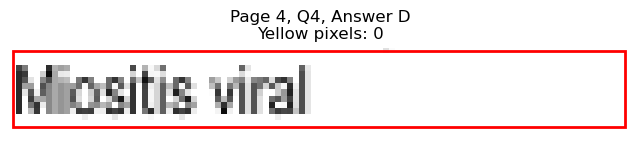


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=417.6, x1=99.4, y1=430.3
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 161
Page 4, Q5, A: Yellow percentage: 0.0%


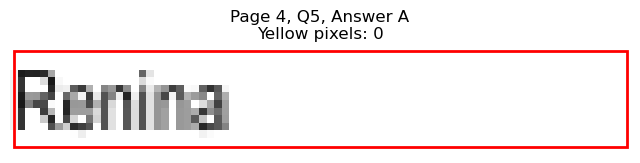

Page 4, Q5 - B: Detected box: x0=327.0, y0=379.7, x1=427.9, y1=392.4
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 498
Page 4, Q5, B: Yellow percentage: 0.0%


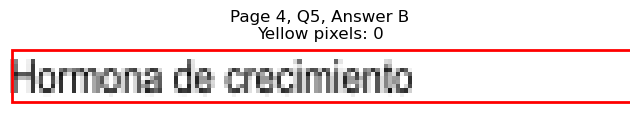

Page 4, Q5 - C: Detected box: x0=327.5, y0=392.3, x1=449.5, y1=405.0
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 779
Page 4, Q5, C: Yellow percentage: 0.0%


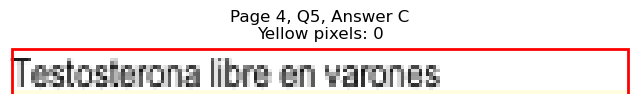

Page 4, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=489.6, y1=417.6
Page 4, Q5, D: Yellow pixels: 2146
Page 4, Q5, D: Total non-white pixels: 2982
Page 4, Q5, D: Yellow percentage: 72.0%


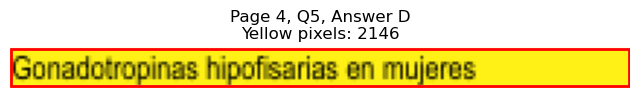


Page 4, Q5 - Selected Answer: D (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=110.9, y1=468.1
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 246
Page 4, Q6, A: Yellow percentage: 0.0%


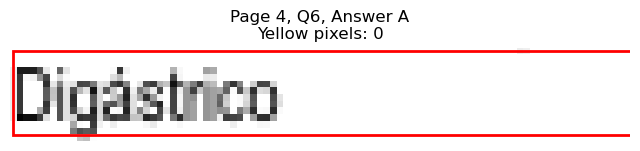

Page 4, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=124.0, y1=480.7
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 264
Page 4, Q6, B: Yellow percentage: 0.0%


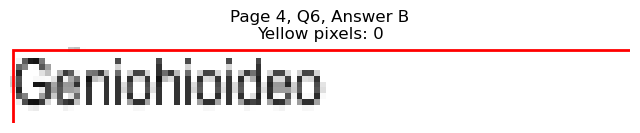

Page 4, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=375.7, y1=468.1
Page 4, Q6, C: Yellow pixels: 1060
Page 4, Q6, C: Total non-white pixels: 1386
Page 4, Q6, C: Yellow percentage: 76.5%


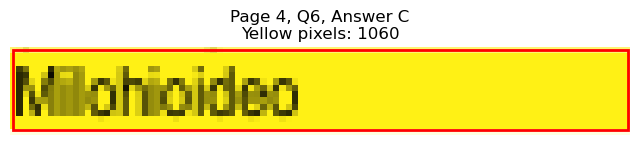

Page 4, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=381.2, y1=480.7
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 384
Page 4, Q6, D: Yellow percentage: 0.0%


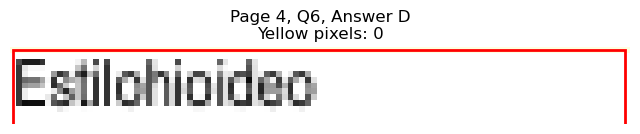


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=518.6, x1=163.1, y1=531.2
Page 4, Q7, A: Yellow pixels: 1531
Page 4, Q7, A: Total non-white pixels: 2044
Page 4, Q7, A: Yellow percentage: 74.9%


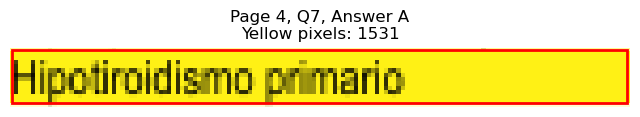

Page 4, Q7 - B: Detected box: x0=68.3, y0=531.2, x1=162.6, y1=543.8
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 629
Page 4, Q7, B: Yellow percentage: 0.0%


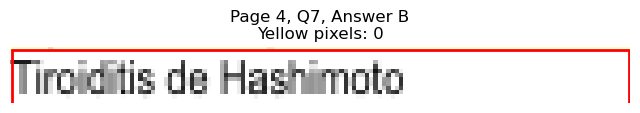

Page 4, Q7 - C: Detected box: x0=327.5, y0=518.6, x1=434.3, y1=531.2
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 578
Page 4, Q7, C: Yellow percentage: 0.0%


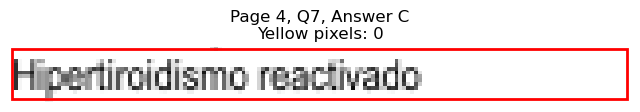

Page 4, Q7 - D: Detected box: x0=327.5, y0=531.2, x1=433.9, y1=543.8
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 568
Page 4, Q7, D: Yellow percentage: 0.0%


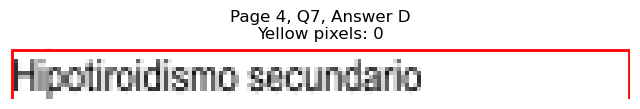


Page 4, Q7 - Selected Answer: A (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=594.3, x1=144.5, y1=607.0
Page 4, Q8, A: Yellow pixels: 1377
Page 4, Q8, A: Total non-white pixels: 1651
Page 4, Q8, A: Yellow percentage: 83.4%


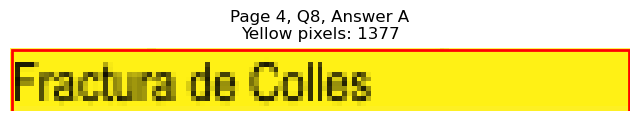

Page 4, Q8 - B: Detected box: x0=68.3, y0=606.9, x1=139.1, y1=619.6
Page 4, Q8, B: Yellow pixels: 122
Page 4, Q8, B: Total non-white pixels: 448
Page 4, Q8, B: Yellow percentage: 27.2%


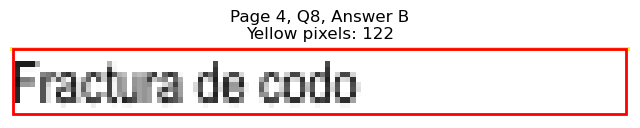

Page 4, Q8 - C: Detected box: x0=327.5, y0=594.3, x1=401.3, y1=607.0
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 341
Page 4, Q8, C: Yellow percentage: 0.0%


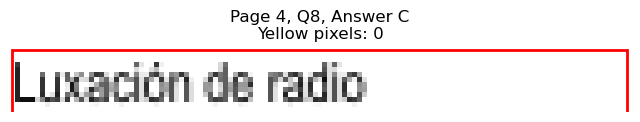

Page 4, Q8 - D: Detected box: x0=327.5, y0=606.9, x1=432.4, y1=619.6
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 524
Page 4, Q8, D: Yellow percentage: 0.0%


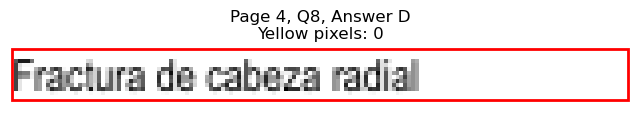


Page 4, Q8 - Selected Answer: A (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=682.7, x1=116.4, y1=695.3
Page 4, Q9, A: Yellow pixels: 994
Page 4, Q9, A: Total non-white pixels: 1386
Page 4, Q9, A: Yellow percentage: 71.7%


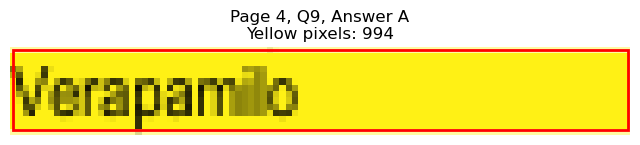

Page 4, Q9 - B: Detected box: x0=68.3, y0=695.4, x1=121.5, y1=708.0
Page 4, Q9, B: Yellow pixels: 1
Page 4, Q9, B: Total non-white pixels: 380
Page 4, Q9, B: Yellow percentage: 0.3%


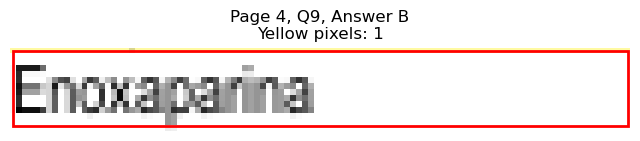

Page 4, Q9 - C: Detected box: x0=327.5, y0=682.7, x1=369.2, y1=695.3
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 179
Page 4, Q9, C: Yellow percentage: 0.0%


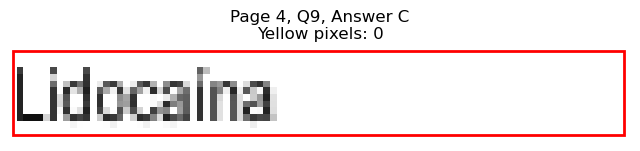

Page 4, Q9 - D: Detected box: x0=327.5, y0=695.4, x1=372.7, y1=708.0
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 219
Page 4, Q9, D: Yellow percentage: 0.0%


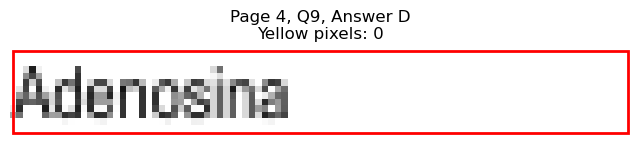


Page 4, Q9 - Selected Answer: A (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=745.8, x1=123.5, y1=758.4
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 282
Page 4, Q10, A: Yellow percentage: 0.0%


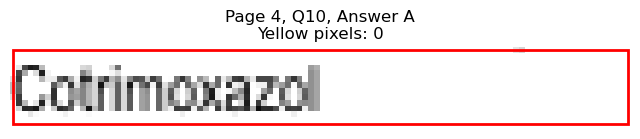

Page 4, Q10 - B: Detected box: x0=68.3, y0=758.5, x1=116.4, y1=771.2
Page 4, Q10, B: Yellow pixels: 1079
Page 4, Q10, B: Total non-white pixels: 1386
Page 4, Q10, B: Yellow percentage: 77.8%


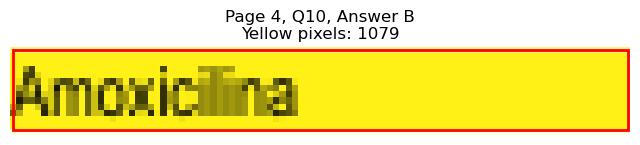

Page 4, Q10 - C: Detected box: x0=327.5, y0=745.8, x1=380.2, y1=758.4
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 275
Page 4, Q10, C: Yellow percentage: 0.0%


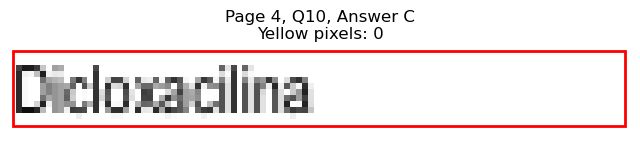

Page 4, Q10 - D: Detected box: x0=327.5, y0=758.5, x1=373.7, y1=771.2
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 237
Page 4, Q10, D: Yellow percentage: 0.0%


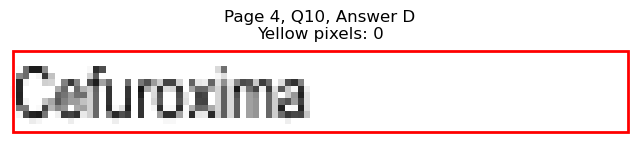


Page 4, Q10 - Selected Answer: B (based on yellow pixel count)





Page 5: Found 9 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=116.9, y1=114.7
Page 5, Q1, A: Yellow pixels: 1131
Page 5, Q1, A: Total non-white pixels: 1287
Page 5, Q1, A: Yellow percentage: 87.9%


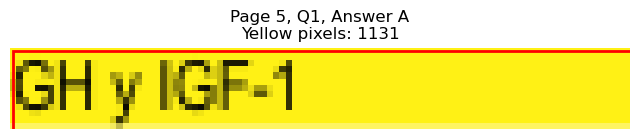

Page 5, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=111.9, y1=127.3
Page 5, Q1, B: Yellow pixels: 93
Page 5, Q1, B: Total non-white pixels: 292
Page 5, Q1, B: Yellow percentage: 31.8%


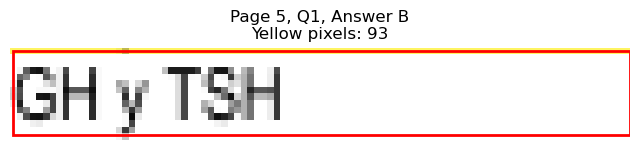

Page 5, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=348.1, y1=114.7
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 97
Page 5, Q1, C: Yellow percentage: 0.0%


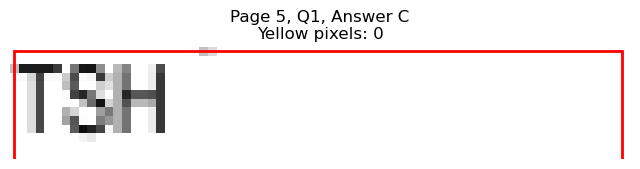

Page 5, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=362.1, y1=127.3
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 171
Page 5, Q1, D: Yellow percentage: 0.0%


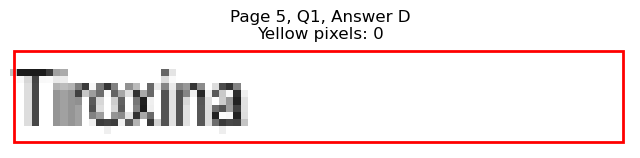


Page 5, Q1 - Selected Answer: A (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=65.2, y1=177.8
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 67
Page 5, Q2, A: Yellow percentage: 0.0%


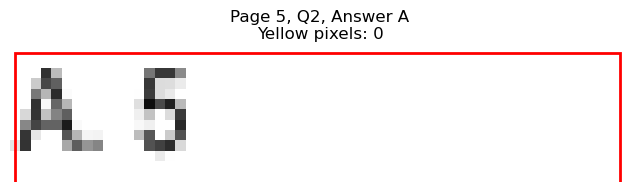

Page 5, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=65.2, y1=190.4
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 66
Page 5, Q2, B: Yellow percentage: 0.0%


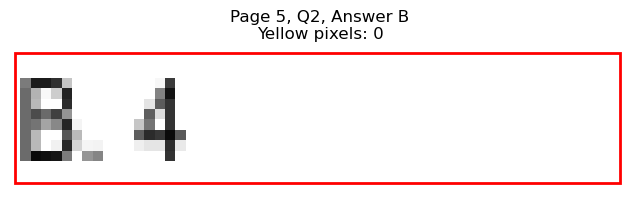

Page 5, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=324.4, y1=177.8
Page 5, Q2, C: Yellow pixels: 735
Page 5, Q2, C: Total non-white pixels: 780
Page 5, Q2, C: Yellow percentage: 94.2%


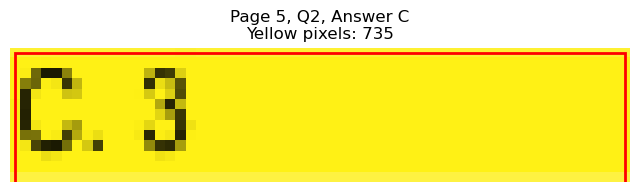

Page 5, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=324.4, y1=190.4
Page 5, Q2, D: Yellow pixels: 60
Page 5, Q2, D: Total non-white pixels: 137
Page 5, Q2, D: Yellow percentage: 43.8%


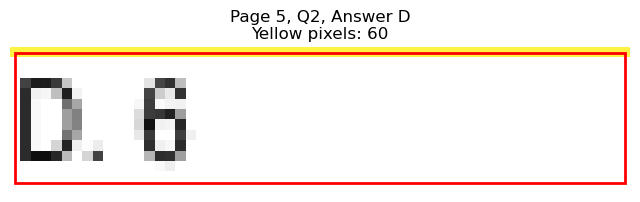


Page 5, Q2 - Selected Answer: C (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=159.6, y1=266.1
Page 5, Q3, A: Yellow pixels: 142
Page 5, Q3, A: Total non-white pixels: 606
Page 5, Q3, A: Yellow percentage: 23.4%


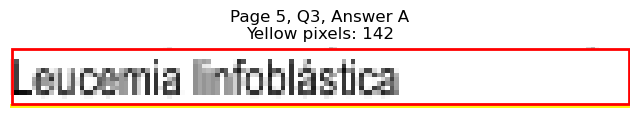

Page 5, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=185.2, y1=278.7
Page 5, Q3, B: Yellow pixels: 1745
Page 5, Q3, B: Total non-white pixels: 2184
Page 5, Q3, B: Yellow percentage: 79.9%


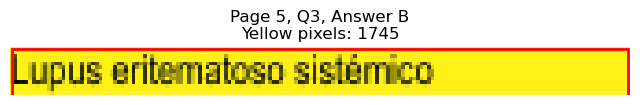

Page 5, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=424.4, y1=266.1
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 524
Page 5, Q3, C: Yellow percentage: 0.0%


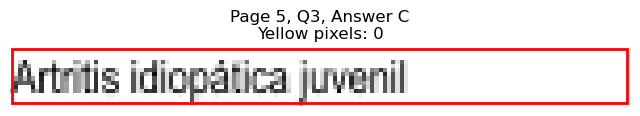

Page 5, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=406.3, y1=278.7
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 409
Page 5, Q3, D: Yellow percentage: 0.0%


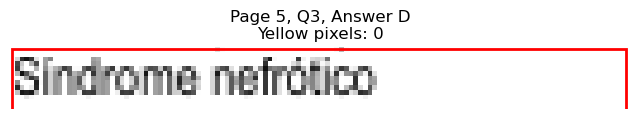


Page 5, Q3 - Selected Answer: B (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=101.4, y1=329.3
Page 5, Q4, A: Yellow pixels: 84
Page 5, Q4, A: Total non-white pixels: 261
Page 5, Q4, A: Yellow percentage: 32.2%


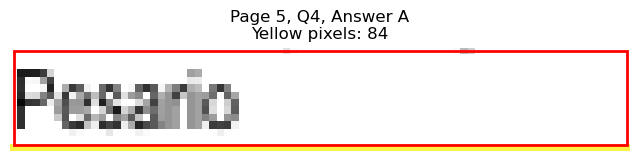

Page 5, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=122.4, y1=341.9
Page 5, Q4, B: Yellow pixels: 1164
Page 5, Q4, B: Total non-white pixels: 1365
Page 5, Q4, B: Yellow percentage: 85.3%


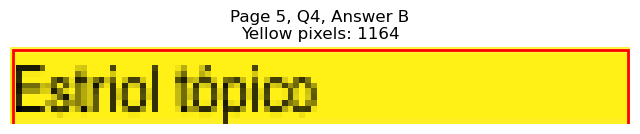

Page 5, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=406.3, y1=329.3
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 405
Page 5, Q4, C: Yellow percentage: 0.0%


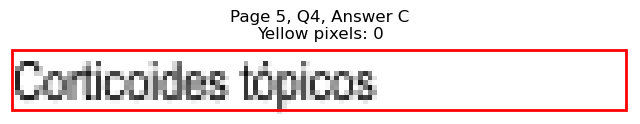

Page 5, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=410.3, y1=341.9
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 457
Page 5, Q4, D: Yellow percentage: 0.0%


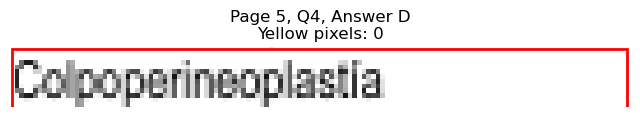


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=392.3, x1=151.6, y1=405.0
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 540
Page 5, Q5, A: Yellow percentage: 0.0%


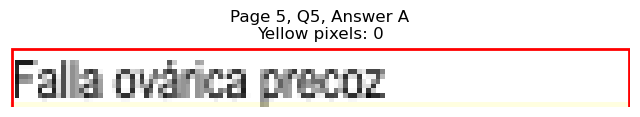

Page 5, Q5 - B: Detected box: x0=68.3, y0=404.9, x1=128.4, y1=417.6
Page 5, Q5, B: Yellow pixels: 1204
Page 5, Q5, B: Total non-white pixels: 1554
Page 5, Q5, B: Yellow percentage: 77.5%


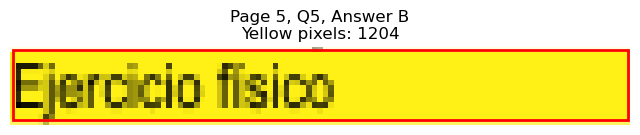

Page 5, Q5 - C: Detected box: x0=327.5, y0=392.3, x1=387.2, y1=405.0
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 329
Page 5, Q5, C: Yellow percentage: 0.0%


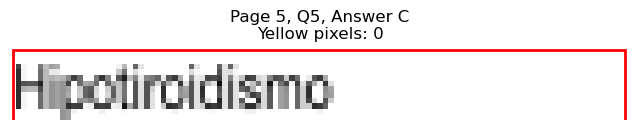

Page 5, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=456.4, y1=417.6
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 658
Page 5, Q5, D: Yellow percentage: 0.0%


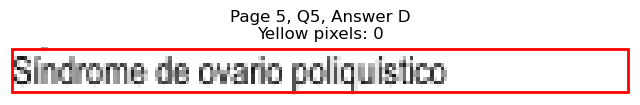


Page 5, Q5 - Selected Answer: B (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=468.1, x1=140.1, y1=480.7
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 348
Page 5, Q6, A: Yellow percentage: 0.0%


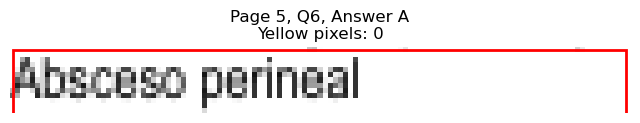

Page 5, Q6 - B: Detected box: x0=68.3, y0=480.8, x1=132.5, y1=493.4
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 324
Page 5, Q6, B: Yellow percentage: 0.0%


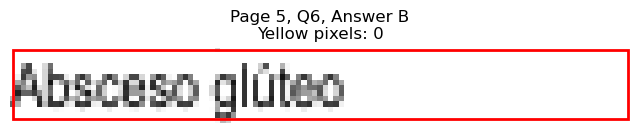

Page 5, Q6 - C: Detected box: x0=327.5, y0=468.1, x1=422.3, y1=480.7
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 490
Page 5, Q6, C: Yellow percentage: 0.0%


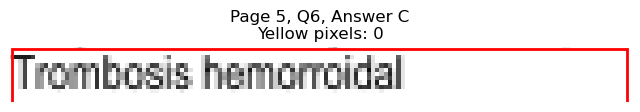

Page 5, Q6 - D: Detected box: x0=327.5, y0=480.8, x1=417.8, y1=493.4
Page 5, Q6, D: Yellow pixels: 1328
Page 5, Q6, D: Total non-white pixels: 1974
Page 5, Q6, D: Yellow percentage: 67.3%


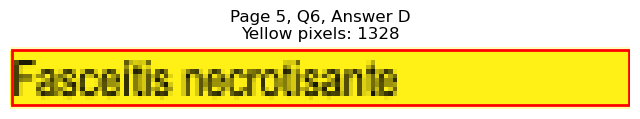


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=543.8, x1=130.5, y1=556.4
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 305
Page 5, Q7, A: Yellow percentage: 0.0%


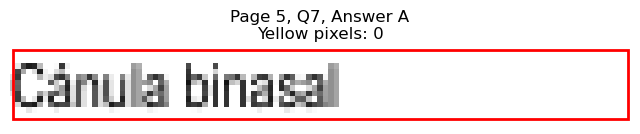

Page 5, Q7 - B: Detected box: x0=68.3, y0=556.5, x1=160.6, y1=569.2
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 466
Page 5, Q7, B: Yellow percentage: 0.0%


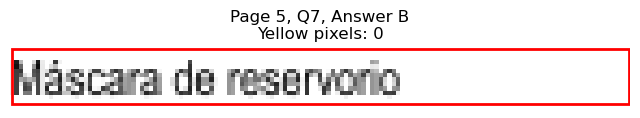

Page 5, Q7 - C: Detected box: x0=327.5, y0=543.8, x1=407.3, y1=556.4
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 398
Page 5, Q7, C: Yellow percentage: 0.0%


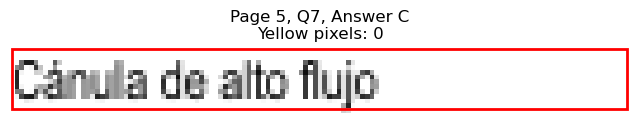

Page 5, Q7 - D: Detected box: x0=327.5, y0=556.5, x1=450.4, y1=569.2
Page 5, Q7, D: Yellow pixels: 1792
Page 5, Q7, D: Total non-white pixels: 2436
Page 5, Q7, D: Yellow percentage: 73.6%


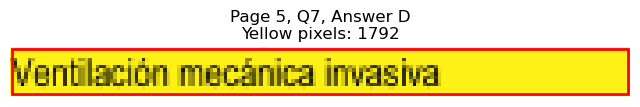


Page 5, Q7 - Selected Answer: D (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=619.6, x1=169.6, y1=632.3
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 494
Page 5, Q8, A: Yellow percentage: 0.0%


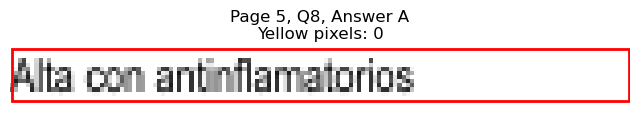

Page 5, Q8 - B: Detected box: x0=68.3, y0=632.2, x1=242.3, y1=644.9
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 875
Page 5, Q8, B: Yellow percentage: 0.0%


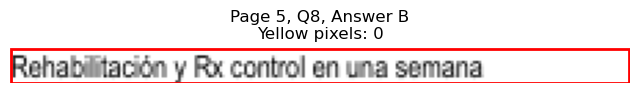

Page 5, Q8 - C: Detected box: x0=327.5, y0=619.6, x1=507.6, y1=632.3
Page 5, Q8, C: Yellow pixels: 1858
Page 5, Q8, C: Total non-white pixels: 2996
Page 5, Q8, C: Yellow percentage: 62.0%


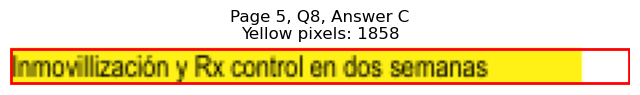

Page 5, Q8 - D: Detected box: x0=327.5, y0=632.2, x1=434.9, y1=644.9
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 701
Page 5, Q8, D: Yellow percentage: 0.0%


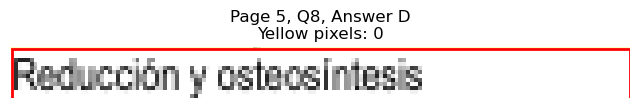


Page 5, Q8 - Selected Answer: C (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=56.6, y0=708.0, x1=65.2, y1=720.6
Page 5, Q9, A: Yellow pixels: 60
Page 5, Q9, A: Total non-white pixels: 125
Page 5, Q9, A: Yellow percentage: 48.0%


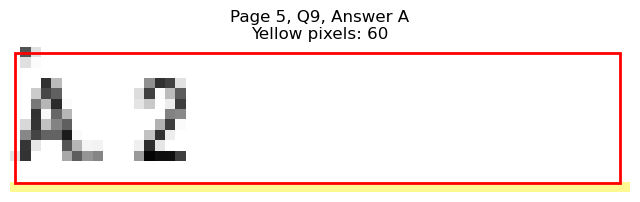

Page 5, Q9 - B: Detected box: x0=56.6, y0=177.7, x1=65.2, y1=190.4
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 66
Page 5, Q9, B: Yellow percentage: 0.0%


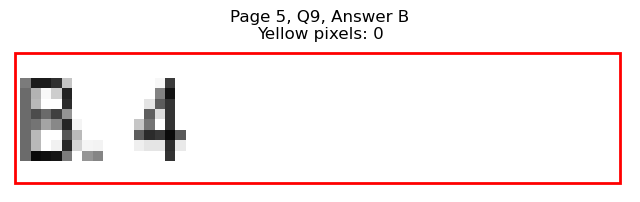

Page 5, Q9 - C: Detected box: x0=315.4, y0=165.1, x1=324.4, y1=177.8
Page 5, Q9, C: Yellow pixels: 735
Page 5, Q9, C: Total non-white pixels: 780
Page 5, Q9, C: Yellow percentage: 94.2%


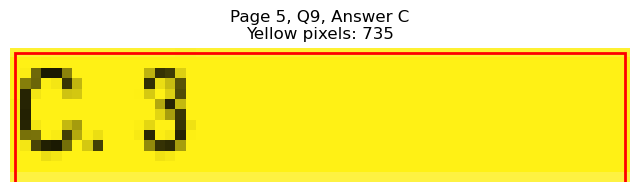

Page 5, Q9 - D: Detected box: x0=315.4, y0=720.6, x1=324.4, y1=733.2
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 71
Page 5, Q9, D: Yellow percentage: 0.0%


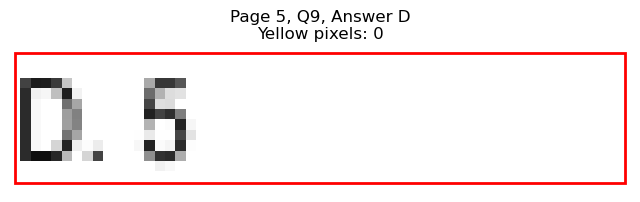


Page 5, Q9 - Selected Answer: C (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=147.1, y1=127.3
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 399
Page 6, Q1, A: Yellow percentage: 0.0%


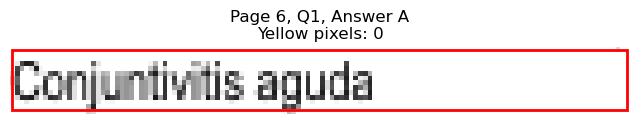

Page 6, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=150.0, y1=139.9
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 413
Page 6, Q1, B: Yellow percentage: 0.0%


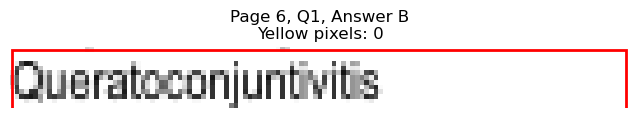

Page 6, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=398.9, y1=127.3
Page 6, Q1, C: Yellow pixels: 122
Page 6, Q1, C: Total non-white pixels: 471
Page 6, Q1, C: Yellow percentage: 25.9%


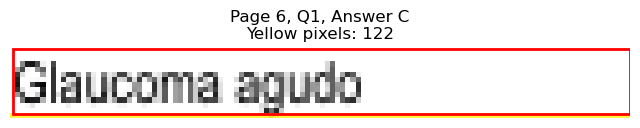

Page 6, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=396.8, y1=139.9
Page 6, Q1, D: Yellow pixels: 1263
Page 6, Q1, D: Total non-white pixels: 1560
Page 6, Q1, D: Yellow percentage: 81.0%


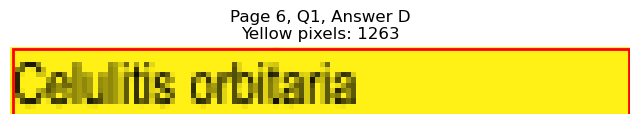


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=167.1, y1=203.0
Page 6, Q2, A: Yellow pixels: 1522
Page 6, Q2, A: Total non-white pixels: 1950
Page 6, Q2, A: Yellow percentage: 78.1%


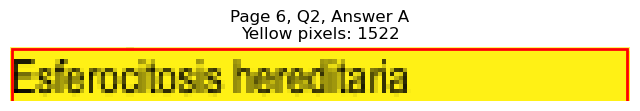

Page 6, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=217.7, y1=215.6
Page 6, Q2, B: Yellow pixels: 200
Page 6, Q2, B: Total non-white pixels: 937
Page 6, Q2, B: Yellow percentage: 21.3%


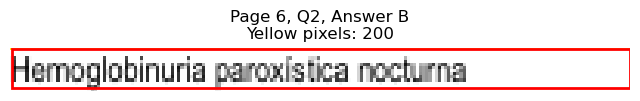

Page 6, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=396.3, y1=203.0
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 353
Page 6, Q2, C: Yellow percentage: 0.0%


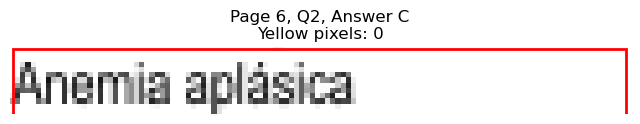

Page 6, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=423.3, y1=215.6
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 513
Page 6, Q2, D: Yellow percentage: 0.0%


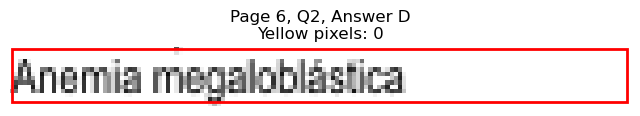


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=149.1, y1=266.1
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 390
Page 6, Q3, A: Yellow percentage: 0.0%


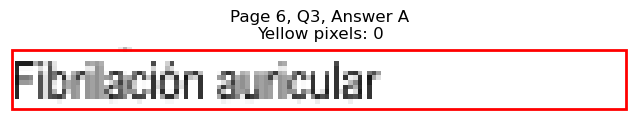

Page 6, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=133.5, y1=278.7
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 311
Page 6, Q3, B: Yellow percentage: 0.0%


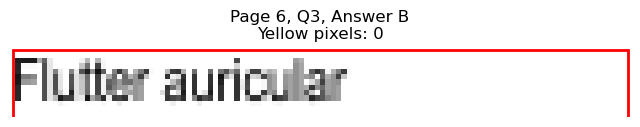

Page 6, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=413.8, y1=266.1
Page 6, Q3, C: Yellow pixels: 137
Page 6, Q3, C: Total non-white pixels: 600
Page 6, Q3, C: Yellow percentage: 22.8%


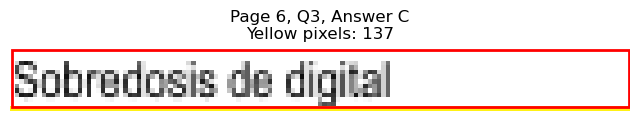

Page 6, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=471.5, y1=278.7
Page 6, Q3, D: Yellow pixels: 1933
Page 6, Q3, D: Total non-white pixels: 2535
Page 6, Q3, D: Yellow percentage: 76.3%


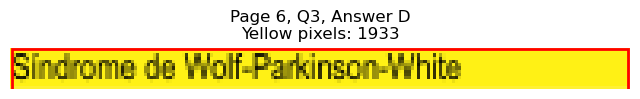


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=329.2, x1=123.5, y1=341.9
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 295
Page 6, Q4, A: Yellow percentage: 0.0%


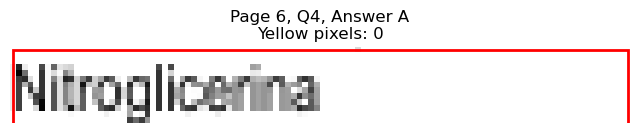

Page 6, Q4 - B: Detected box: x0=68.3, y0=341.9, x1=107.4, y1=354.6
Page 6, Q4, B: Yellow pixels: 1008
Page 6, Q4, B: Total non-white pixels: 1260
Page 6, Q4, B: Yellow percentage: 80.0%


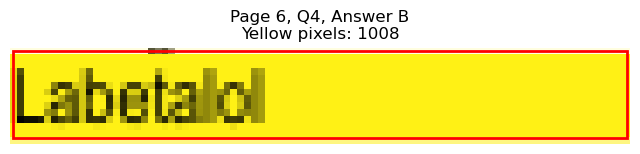

Page 6, Q4 - C: Detected box: x0=327.5, y0=329.2, x1=362.1, y1=341.9
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 176
Page 6, Q4, C: Yellow percentage: 0.0%


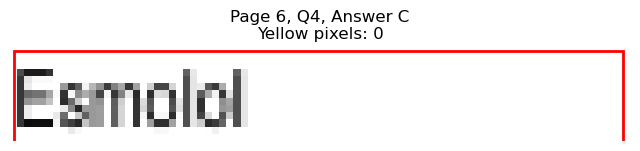

Page 6, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=417.8, y1=354.6
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 455
Page 6, Q4, D: Yellow percentage: 0.0%


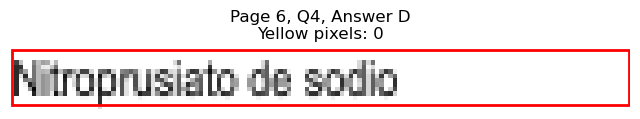


Page 6, Q4 - Selected Answer: B (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=113.9, y1=392.4
Page 6, Q5, A: Yellow pixels: 96
Page 6, Q5, A: Total non-white pixels: 329
Page 6, Q5, A: Yellow percentage: 29.2%


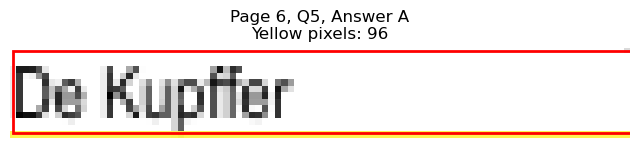

Page 6, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=110.9, y1=405.0
Page 6, Q5, B: Yellow pixels: 1045
Page 6, Q5, B: Total non-white pixels: 1209
Page 6, Q5, B: Yellow percentage: 86.4%


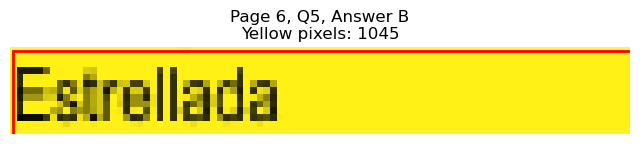

Page 6, Q5 - C: Detected box: x0=327.5, y0=379.7, x1=373.1, y1=392.4
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 241
Page 6, Q5, C: Yellow percentage: 0.0%


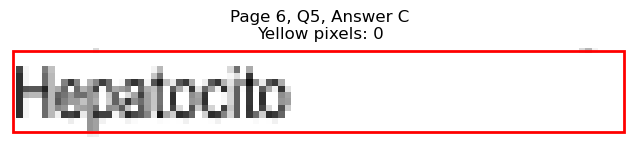

Page 6, Q5 - D: Detected box: x0=327.5, y0=392.3, x1=412.3, y1=405.0
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 459
Page 6, Q5, D: Yellow percentage: 0.0%


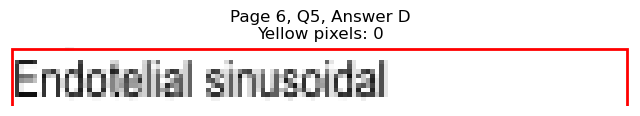


Page 6, Q5 - Selected Answer: B (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=263.0, y1=468.1
Page 6, Q6, A: Yellow pixels: 2032
Page 6, Q6, A: Total non-white pixels: 2996
Page 6, Q6, A: Yellow percentage: 67.8%


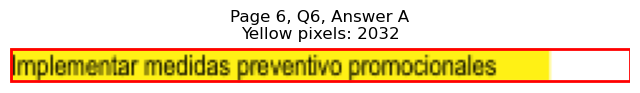

Page 6, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=222.4, y1=480.7
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 1009
Page 6, Q6, B: Yellow percentage: 0.0%


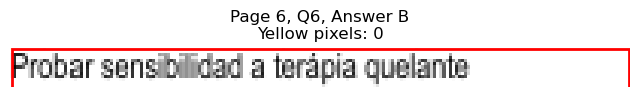

Page 6, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=459.5, y1=468.1
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 689
Page 6, Q6, C: Yellow percentage: 0.0%


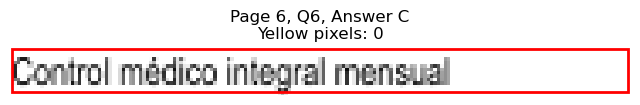

Page 6, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=519.7, y1=480.7
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 981
Page 6, Q6, D: Yellow percentage: 0.0%


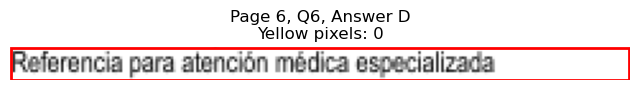


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=531.2, x1=133.5, y1=543.8
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 318
Page 6, Q7, A: Yellow percentage: 0.0%


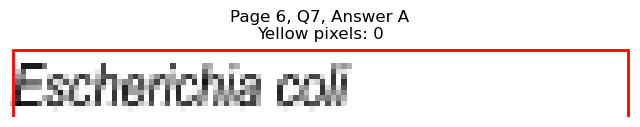

Page 6, Q7 - B: Detected box: x0=68.3, y0=543.8, x1=159.0, y1=556.4
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 452
Page 6, Q7, B: Yellow percentage: 0.0%


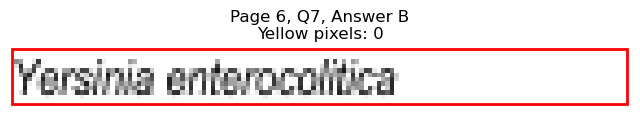

Page 6, Q7 - C: Detected box: x0=327.5, y0=531.2, x1=411.8, y1=543.8
Page 6, Q7, C: Yellow pixels: 1400
Page 6, Q7, C: Total non-white pixels: 1755
Page 6, Q7, C: Yellow percentage: 79.8%


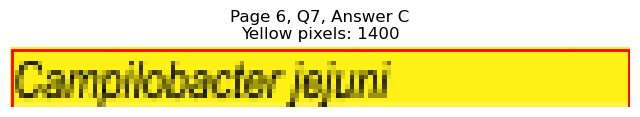

Page 6, Q7 - D: Detected box: x0=327.5, y0=543.8, x1=376.1, y1=556.4
Page 6, Q7, D: Yellow pixels: 94
Page 6, Q7, D: Total non-white pixels: 342
Page 6, Q7, D: Yellow percentage: 27.5%


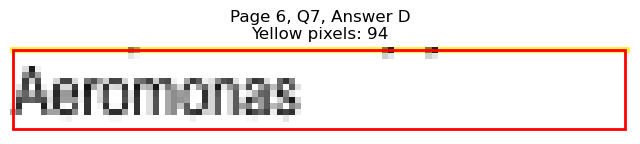


Page 6, Q7 - Selected Answer: C (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=594.3, x1=172.1, y1=607.0
Page 6, Q8, A: Yellow pixels: 1623
Page 6, Q8, A: Total non-white pixels: 2015
Page 6, Q8, A: Yellow percentage: 80.5%


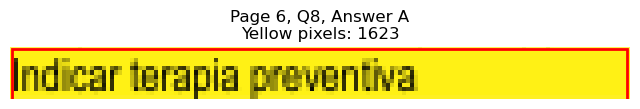

Page 6, Q8 - B: Detected box: x0=68.3, y0=606.9, x1=184.2, y1=619.6
Page 6, Q8, B: Yellow pixels: 164
Page 6, Q8, B: Total non-white pixels: 742
Page 6, Q8, B: Yellow percentage: 22.1%


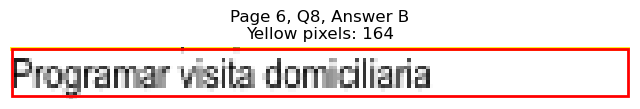

Page 6, Q8 - C: Detected box: x0=327.5, y0=594.3, x1=410.3, y1=607.0
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 408
Page 6, Q8, C: Yellow percentage: 0.0%


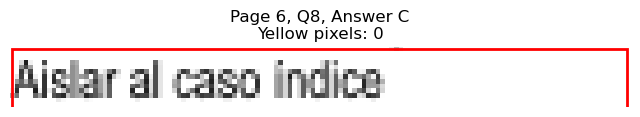

Page 6, Q8 - D: Detected box: x0=327.5, y0=606.9, x1=416.8, y1=619.6
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 436
Page 6, Q8, D: Yellow percentage: 0.0%


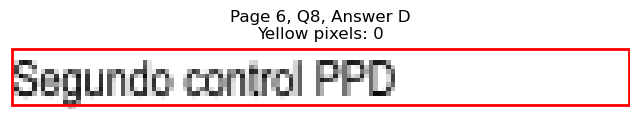


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=670.1, x1=204.8, y1=682.7
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 868
Page 6, Q9, A: Yellow percentage: 0.0%


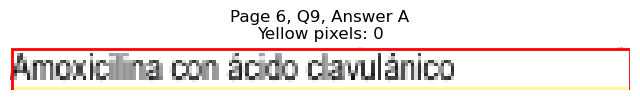

Page 6, Q9 - B: Detected box: x0=68.3, y0=682.7, x1=113.9, y1=695.3
Page 6, Q9, B: Yellow pixels: 988
Page 6, Q9, B: Total non-white pixels: 1344
Page 6, Q9, B: Yellow percentage: 73.5%


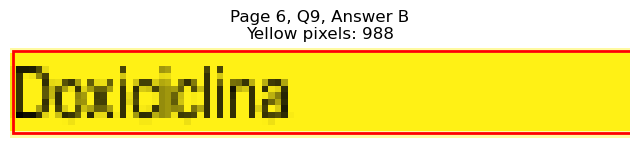

Page 6, Q9 - C: Detected box: x0=327.5, y0=670.1, x1=375.7, y1=682.7
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 244
Page 6, Q9, C: Yellow percentage: 0.0%


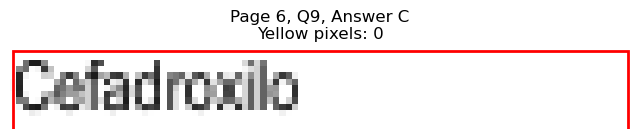

Page 6, Q9 - D: Detected box: x0=327.5, y0=682.7, x1=385.3, y1=695.3
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 274
Page 6, Q9, D: Yellow percentage: 0.0%


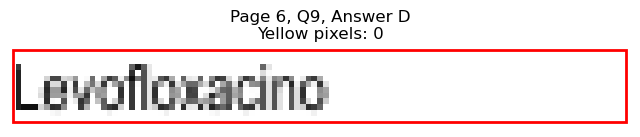


Page 6, Q9 - Selected Answer: B (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=720.6, x1=103.9, y1=733.2
Page 6, Q10, A: Yellow pixels: 86
Page 6, Q10, A: Total non-white pixels: 281
Page 6, Q10, A: Yellow percentage: 30.6%


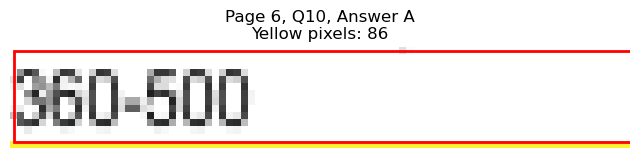

Page 6, Q10 - B: Detected box: x0=68.3, y0=733.2, x1=98.9, y1=745.8
Page 6, Q10, B: Yellow pixels: 943
Page 6, Q10, B: Total non-white pixels: 1053
Page 6, Q10, B: Yellow percentage: 89.6%


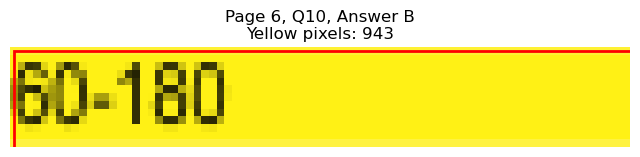

Page 6, Q10 - C: Detected box: x0=327.5, y0=720.6, x1=363.2, y1=733.2
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 175
Page 6, Q10, C: Yellow percentage: 0.0%


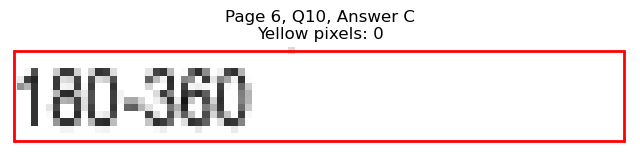

Page 6, Q10 - D: Detected box: x0=327.5, y0=733.2, x1=350.7, y1=745.8
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 113
Page 6, Q10, D: Yellow percentage: 0.0%


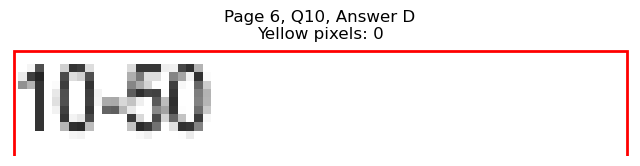


Page 6, Q10 - Selected Answer: B (based on yellow pixel count)





Page 7: Found 9 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=177.1, y1=114.7
Page 7, Q1, A: Yellow pixels: 1669
Page 7, Q1, A: Total non-white pixels: 2080
Page 7, Q1, A: Yellow percentage: 80.2%


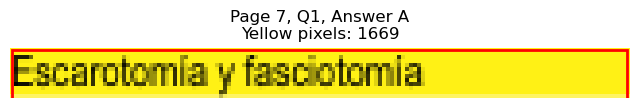

Page 7, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=249.4, y1=127.3
Page 7, Q1, B: Yellow pixels: 212
Page 7, Q1, B: Total non-white pixels: 1125
Page 7, Q1, B: Yellow percentage: 18.8%


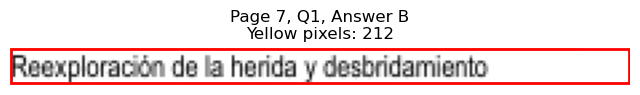

Page 7, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=415.3, y1=114.7
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 454
Page 7, Q1, C: Yellow percentage: 0.0%


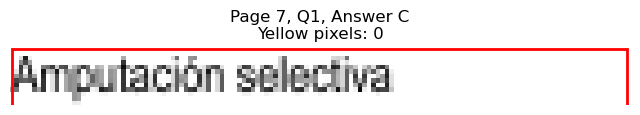

Page 7, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=422.3, y1=127.3
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 500
Page 7, Q1, D: Yellow percentage: 0.0%


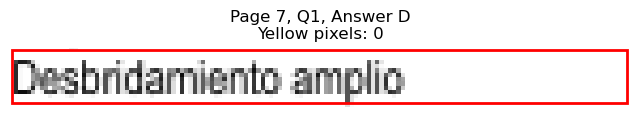


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=171.1, y1=177.8
Page 7, Q2, A: Yellow pixels: 1607
Page 7, Q2, A: Total non-white pixels: 2002
Page 7, Q2, A: Yellow percentage: 80.3%


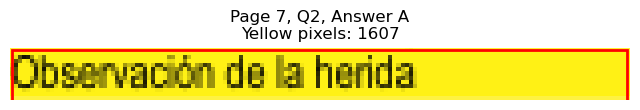

Page 7, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=150.0, y1=190.4
Page 7, Q2, B: Yellow pixels: 133
Page 7, Q2, B: Total non-white pixels: 554
Page 7, Q2, B: Yellow percentage: 24.0%


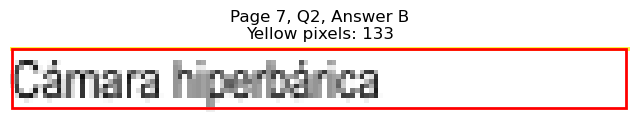

Page 7, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=431.8, y1=177.8
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 532
Page 7, Q2, C: Yellow percentage: 0.0%


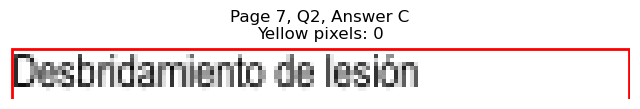

Page 7, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=399.8, y1=190.4
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 372
Page 7, Q2, D: Yellow percentage: 0.0%


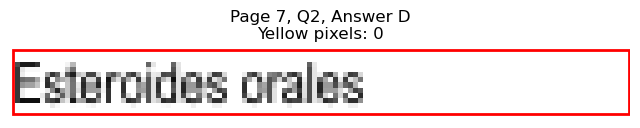


Page 7, Q2 - Selected Answer: A (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=180.1, y1=240.9
Page 7, Q3, A: Yellow pixels: 1678
Page 7, Q3, A: Total non-white pixels: 2119
Page 7, Q3, A: Yellow percentage: 79.2%


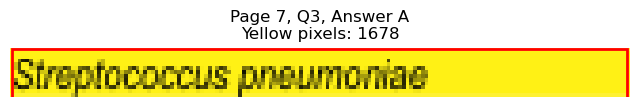

Page 7, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=164.1, y1=253.5
Page 7, Q3, B: Yellow pixels: 144
Page 7, Q3, B: Total non-white pixels: 628
Page 7, Q3, B: Yellow percentage: 22.9%


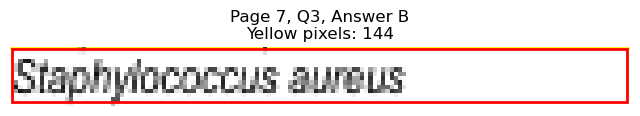

Page 7, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=399.3, y1=240.9
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 375
Page 7, Q3, C: Yellow percentage: 0.0%


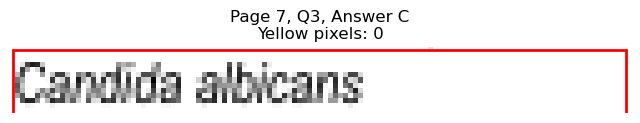

Page 7, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=386.7, y1=253.5
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 293
Page 7, Q3, D: Yellow percentage: 0.0%


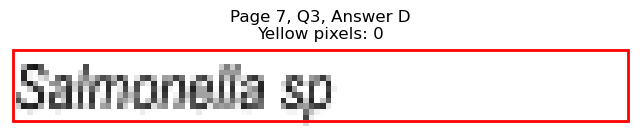


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=109.0, y1=304.1
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 171
Page 7, Q4, A: Yellow percentage: 0.0%


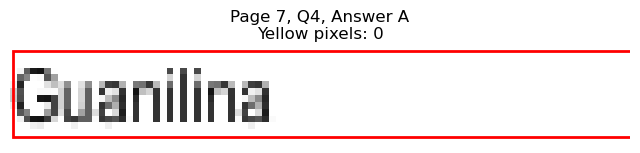

Page 7, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=85.3, y1=316.7
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 68
Page 7, Q4, B: Yellow percentage: 0.0%


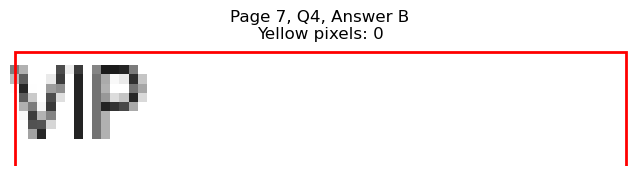

Page 7, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=405.8, y1=304.1
Page 7, Q4, C: Yellow pixels: 1343
Page 7, Q4, C: Total non-white pixels: 1806
Page 7, Q4, C: Yellow percentage: 74.4%


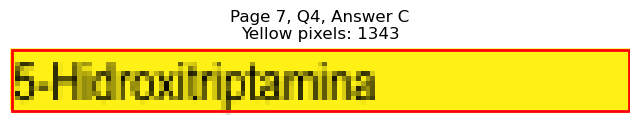

Page 7, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=372.7, y1=316.7
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 315
Page 7, Q4, D: Yellow percentage: 0.0%


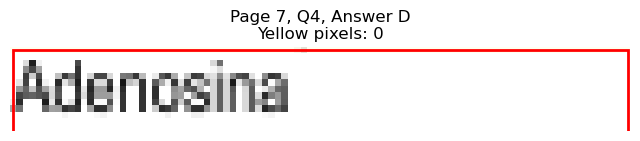


Page 7, Q4 - Selected Answer: C (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=129.5, y1=392.4
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 320
Page 7, Q5, A: Yellow percentage: 0.0%


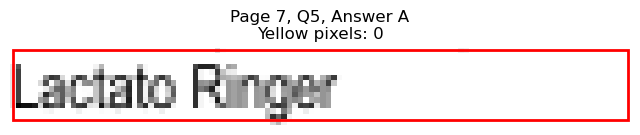

Page 7, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=169.6, y1=405.0
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 482
Page 7, Q5, B: Yellow percentage: 0.0%


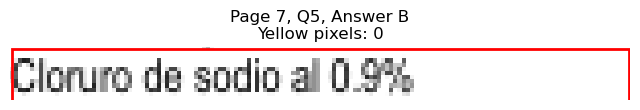

Page 7, Q5 - C: Detected box: x0=327.5, y0=379.7, x1=406.3, y1=392.4
Page 7, Q5, C: Yellow pixels: 1267
Page 7, Q5, C: Total non-white pixels: 1820
Page 7, Q5, C: Yellow percentage: 69.6%


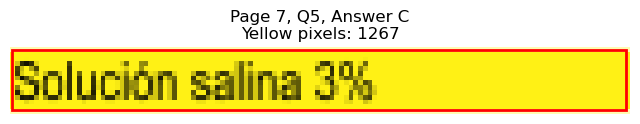

Page 7, Q5 - D: Detected box: x0=327.5, y0=392.3, x1=431.3, y1=405.0
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 663
Page 7, Q5, D: Yellow percentage: 0.0%


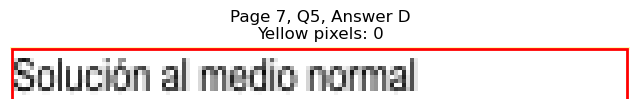


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=455.5, x1=146.5, y1=468.1
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 353
Page 7, Q6, A: Yellow percentage: 0.0%


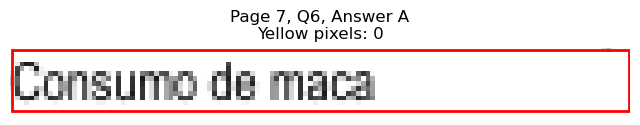

Page 7, Q6 - B: Detected box: x0=68.3, y0=468.1, x1=138.5, y1=480.7
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 343
Page 7, Q6, B: Yellow percentage: 0.0%


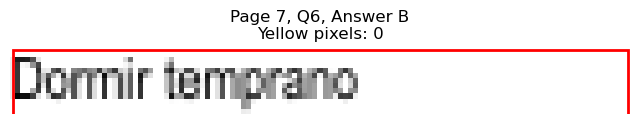

Page 7, Q6 - C: Detected box: x0=327.5, y0=455.5, x1=374.2, y1=468.1
Page 7, Q6, C: Yellow pixels: 98
Page 7, Q6, C: Total non-white pixels: 317
Page 7, Q6, C: Yellow percentage: 30.9%


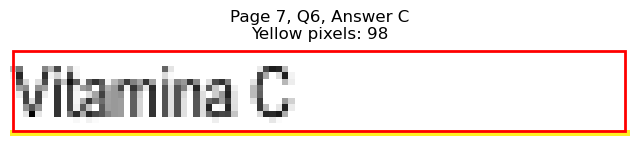

Page 7, Q6 - D: Detected box: x0=327.5, y0=468.1, x1=385.7, y1=480.7
Page 7, Q6, D: Yellow pixels: 1197
Page 7, Q6, D: Total non-white pixels: 1417
Page 7, Q6, D: Yellow percentage: 84.5%


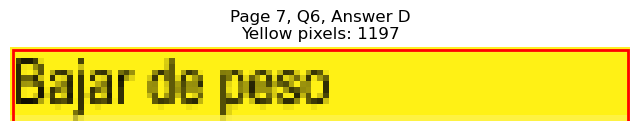


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=543.8, x1=88.3, y1=556.4
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 85
Page 7, Q7, A: Yellow percentage: 0.0%


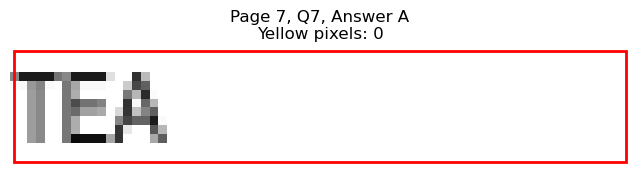

Page 7, Q7 - B: Detected box: x0=68.3, y0=556.5, x1=130.9, y1=569.2
Page 7, Q7, B: Yellow pixels: 1227
Page 7, Q7, B: Total non-white pixels: 1582
Page 7, Q7, B: Yellow percentage: 77.6%


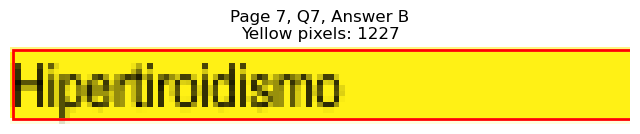

Page 7, Q7 - C: Detected box: x0=327.5, y0=543.8, x1=402.8, y1=556.4
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 384
Page 7, Q7, C: Yellow percentage: 0.0%


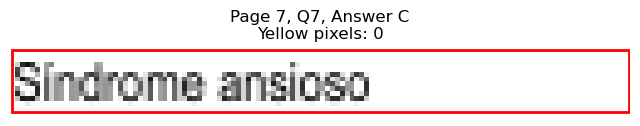

Page 7, Q7 - D: Detected box: x0=327.5, y0=556.5, x1=354.7, y1=569.2
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 126
Page 7, Q7, D: Yellow percentage: 0.0%


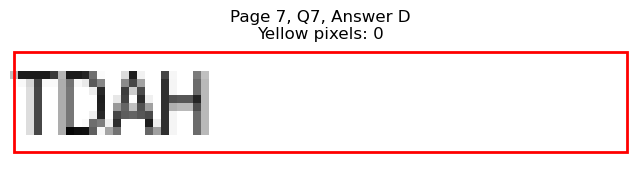


Page 7, Q7 - Selected Answer: B (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=619.6, x1=168.1, y1=632.3
Page 7, Q8, A: Yellow pixels: 1393
Page 7, Q8, A: Total non-white pixels: 2114
Page 7, Q8, A: Yellow percentage: 65.9%


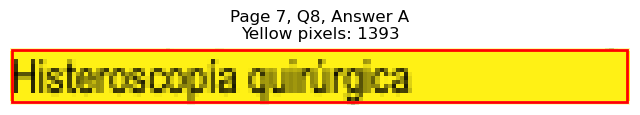

Page 7, Q8 - B: Detected box: x0=68.3, y0=632.2, x1=183.1, y1=644.9
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 788
Page 7, Q8, B: Yellow percentage: 0.0%


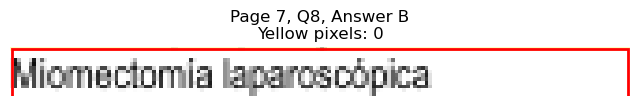

Page 7, Q8 - C: Detected box: x0=327.5, y0=619.6, x1=414.3, y1=632.3
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 446
Page 7, Q8, C: Yellow percentage: 0.0%


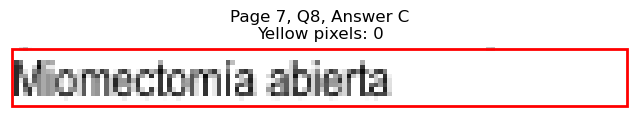

Page 7, Q8 - D: Detected box: x0=327.5, y0=632.2, x1=408.3, y1=644.9
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 389
Page 7, Q8, D: Yellow percentage: 0.0%


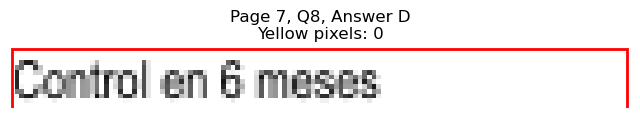


Page 7, Q8 - Selected Answer: A (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=695.4, x1=178.1, y1=708.0
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 552
Page 7, Q9, A: Yellow percentage: 0.0%


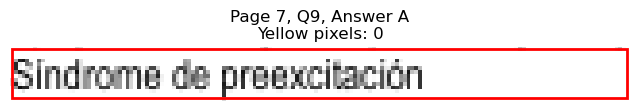

Page 7, Q9 - B: Detected box: x0=68.3, y0=708.0, x1=133.5, y1=720.6
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 313
Page 7, Q9, B: Yellow percentage: 0.0%


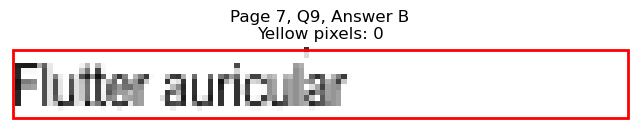

Page 7, Q9 - C: Detected box: x0=327.5, y0=695.4, x1=470.0, y1=708.0
Page 7, Q9, C: Yellow pixels: 1963
Page 7, Q9, C: Total non-white pixels: 2524
Page 7, Q9, C: Yellow percentage: 77.8%


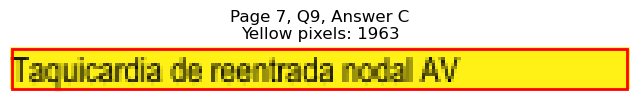

Page 7, Q9 - D: Detected box: x0=327.5, y0=708.0, x1=408.3, y1=720.6
Page 7, Q9, D: Yellow pixels: 130
Page 7, Q9, D: Total non-white pixels: 562
Page 7, Q9, D: Yellow percentage: 23.1%


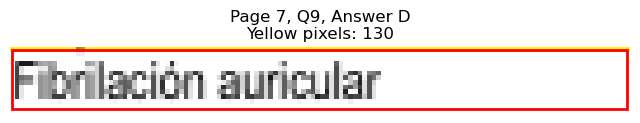


Page 7, Q9 - Selected Answer: C (based on yellow pixel count)





Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=115.5, y1=114.7
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 345
Page 8, Q1, A: Yellow percentage: 0.0%


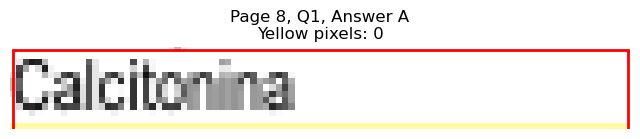

Page 8, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=121.0, y1=127.3
Page 8, Q1, B: Yellow pixels: 1027
Page 8, Q1, B: Total non-white pixels: 1442
Page 8, Q1, B: Yellow percentage: 71.2%


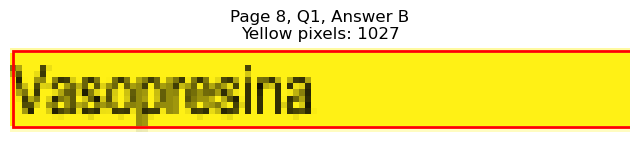

Page 8, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=392.2, y1=114.7
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 321
Page 8, Q1, C: Yellow percentage: 0.0%


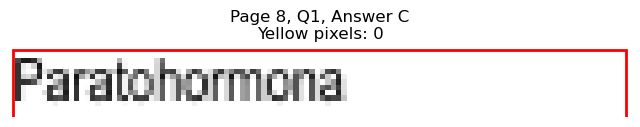

Page 8, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=358.6, y1=127.3
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 159
Page 8, Q1, D: Yellow percentage: 0.0%


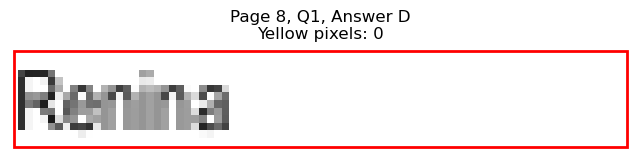


Page 8, Q1 - Selected Answer: B (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=80.9, y1=203.0
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 47
Page 8, Q2, A: Yellow percentage: 0.0%


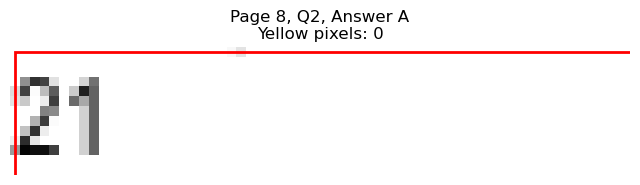

Page 8, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=80.9, y1=215.6
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 42
Page 8, Q2, B: Yellow percentage: 0.0%


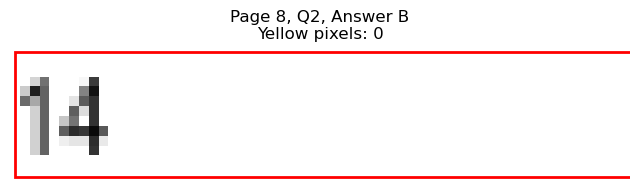

Page 8, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=324.4, y1=203.0
Page 8, Q2, C: Yellow pixels: 740
Page 8, Q2, C: Total non-white pixels: 780
Page 8, Q2, C: Yellow percentage: 94.9%


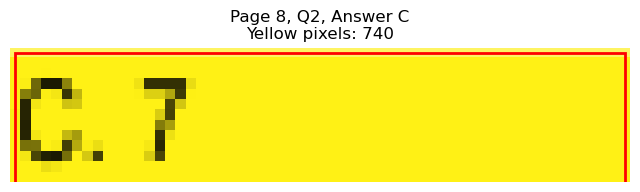

Page 8, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=324.4, y1=215.6
Page 8, Q2, D: Yellow pixels: 60
Page 8, Q2, D: Total non-white pixels: 130
Page 8, Q2, D: Yellow percentage: 46.2%


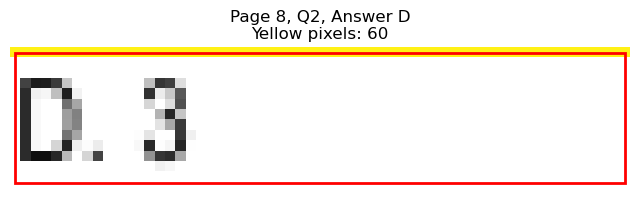


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=195.3, y1=266.1
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 644
Page 8, Q3, A: Yellow percentage: 0.0%


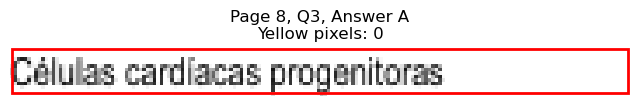

Page 8, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=178.1, y1=278.7
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 599
Page 8, Q3, B: Yellow percentage: 0.0%


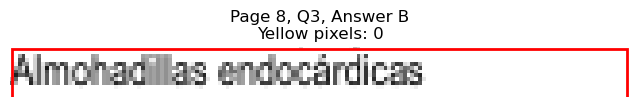

Page 8, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=436.9, y1=266.1
Page 8, Q3, C: Yellow pixels: 1648
Page 8, Q3, C: Total non-white pixels: 2240
Page 8, Q3, C: Yellow percentage: 73.6%


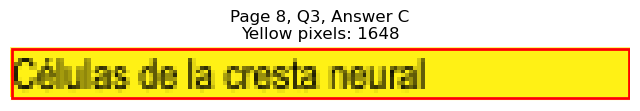

Page 8, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=473.0, y1=278.7
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 931
Page 8, Q3, D: Yellow percentage: 0.0%


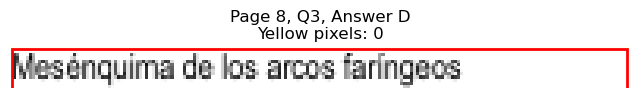


Page 8, Q3 - Selected Answer: C (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=329.2, x1=150.0, y1=341.9
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 408
Page 8, Q4, A: Yellow percentage: 0.0%


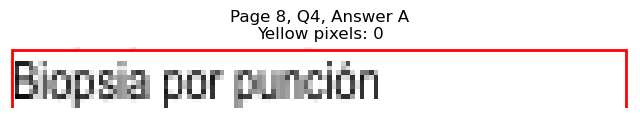

Page 8, Q4 - B: Detected box: x0=68.3, y0=341.9, x1=125.4, y1=354.6
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 305
Page 8, Q4, B: Yellow percentage: 0.0%


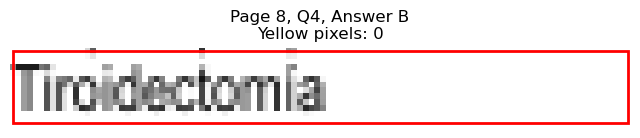

Page 8, Q4 - C: Detected box: x0=327.5, y0=329.2, x1=385.3, y1=341.9
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 294
Page 8, Q4, C: Yellow percentage: 0.0%


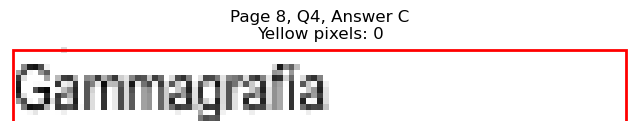

Page 8, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=401.8, y1=354.6
Page 8, Q4, D: Yellow pixels: 1328
Page 8, Q4, D: Total non-white pixels: 1750
Page 8, Q4, D: Yellow percentage: 75.9%


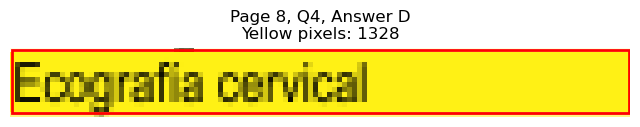


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=115.0, y1=417.6
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 233
Page 8, Q5, A: Yellow percentage: 0.0%


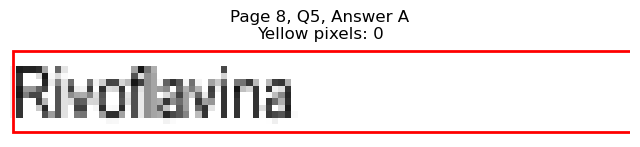

Page 8, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=100.9, y1=430.3
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 159
Page 8, Q5, B: Yellow percentage: 0.0%


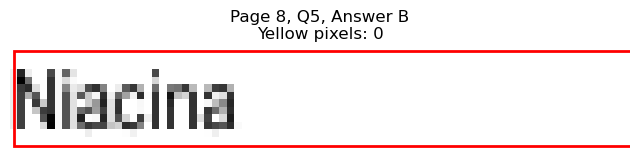

Page 8, Q5 - C: Detected box: x0=327.5, y0=404.9, x1=362.1, y1=417.6
Page 8, Q5, C: Yellow pixels: 993
Page 8, Q5, C: Total non-white pixels: 1204
Page 8, Q5, C: Yellow percentage: 82.5%


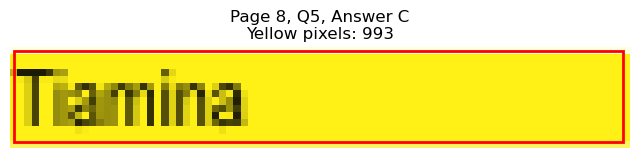

Page 8, Q5 - D: Detected box: x0=327.5, y0=417.6, x1=399.8, y1=430.3
Page 8, Q5, D: Yellow pixels: 123
Page 8, Q5, D: Total non-white pixels: 503
Page 8, Q5, D: Yellow percentage: 24.5%


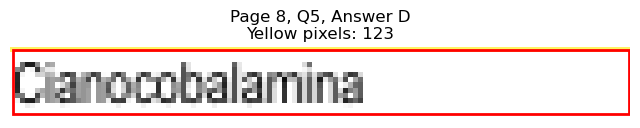


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=56.6, y0=506.0, x1=65.2, y1=518.6
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 56
Page 8, Q6, A: Yellow percentage: 0.0%


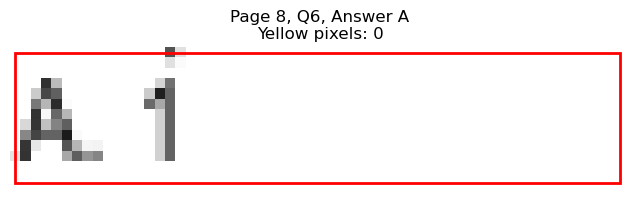

Page 8, Q6 - B: Detected box: x0=56.6, y0=518.6, x1=65.2, y1=531.2
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 66
Page 8, Q6, B: Yellow percentage: 0.0%


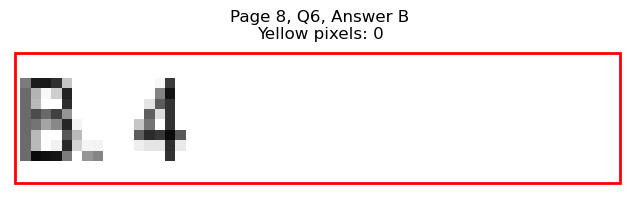

Page 8, Q6 - C: Detected box: x0=315.4, y0=506.0, x1=324.4, y1=518.6
Page 8, Q6, C: Yellow pixels: 734
Page 8, Q6, C: Total non-white pixels: 840
Page 8, Q6, C: Yellow percentage: 87.4%


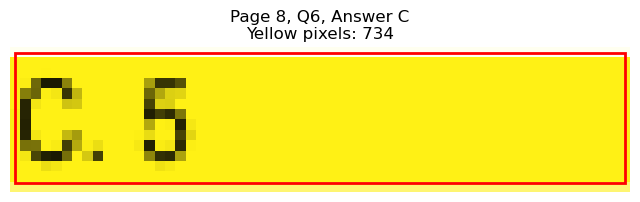

Page 8, Q6 - D: Detected box: x0=315.4, y0=518.6, x1=324.4, y1=531.2
Page 8, Q6, D: Yellow pixels: 60
Page 8, Q6, D: Total non-white pixels: 126
Page 8, Q6, D: Yellow percentage: 47.6%


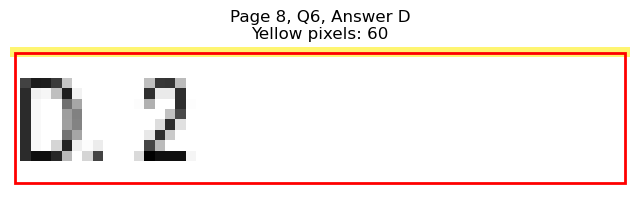


Page 8, Q6 - Selected Answer: C (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=569.1, x1=162.6, y1=581.8
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 506
Page 8, Q7, A: Yellow percentage: 0.0%


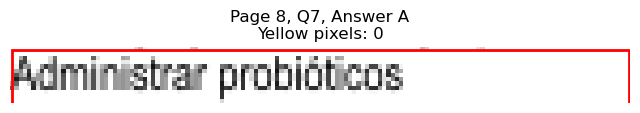

Page 8, Q7 - B: Detected box: x0=68.3, y0=581.7, x1=115.9, y1=594.4
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 255
Page 8, Q7, B: Yellow percentage: 0.0%


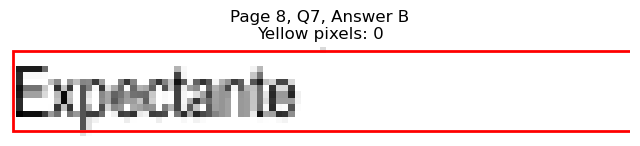

Page 8, Q7 - C: Detected box: x0=327.5, y0=569.1, x1=525.1, y1=581.8
Page 8, Q7, C: Yellow pixels: 2004
Page 8, Q7, C: Total non-white pixels: 2782
Page 8, Q7, C: Yellow percentage: 72.0%


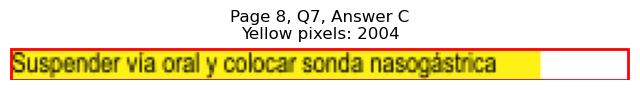

Page 8, Q7 - D: Detected box: x0=327.5, y0=581.7, x1=517.2, y1=594.4
Page 8, Q7, D: Yellow pixels: 211
Page 8, Q7, D: Total non-white pixels: 1150
Page 8, Q7, D: Yellow percentage: 18.3%


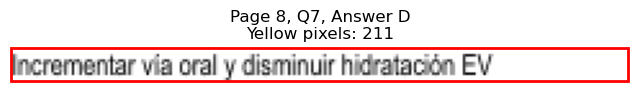


Page 8, Q7 - Selected Answer: C (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=632.2, x1=110.9, y1=644.9
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 213
Page 8, Q8, A: Yellow percentage: 0.0%


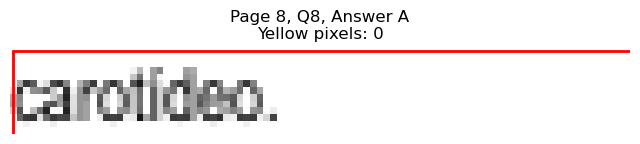

Page 8, Q8 - B: Detected box: x0=68.3, y0=644.9, x1=103.5, y1=657.5
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 151
Page 8, Q8, B: Yellow percentage: 0.0%


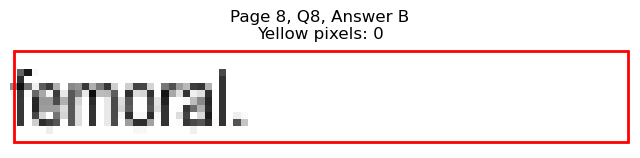

Page 8, Q8 - C: Detected box: x0=327.5, y0=632.2, x1=364.6, y1=644.9
Page 8, Q8, C: Yellow pixels: 1026
Page 8, Q8, C: Total non-white pixels: 1144
Page 8, Q8, C: Yellow percentage: 89.7%


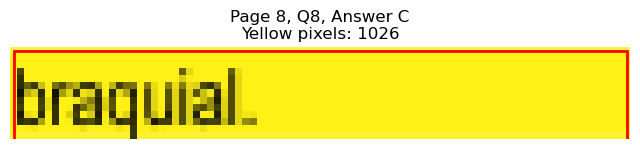

Page 8, Q8 - D: Detected box: x0=327.5, y0=644.9, x1=354.7, y1=657.5
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 117
Page 8, Q8, D: Yellow percentage: 0.0%


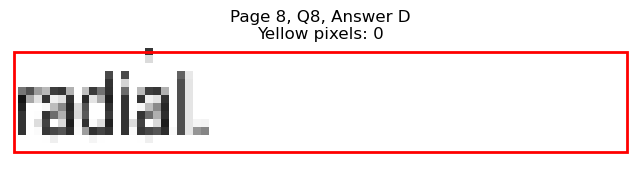


Page 8, Q8 - Selected Answer: C (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=720.6, x1=145.6, y1=733.2
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 423
Page 8, Q9, A: Yellow percentage: 0.0%


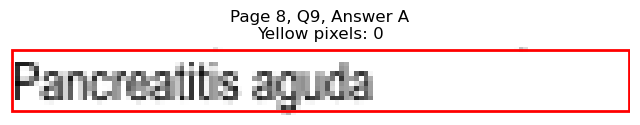

Page 8, Q9 - B: Detected box: x0=68.3, y0=733.2, x1=137.1, y1=745.8
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 348
Page 8, Q9, B: Yellow percentage: 0.0%


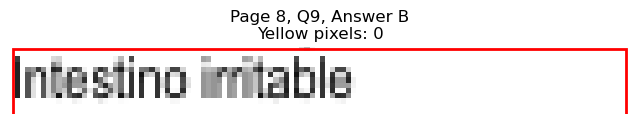

Page 8, Q9 - C: Detected box: x0=327.5, y0=720.6, x1=447.4, y1=733.2
Page 8, Q9, C: Yellow pixels: 171
Page 8, Q9, C: Total non-white pixels: 776
Page 8, Q9, C: Yellow percentage: 22.0%


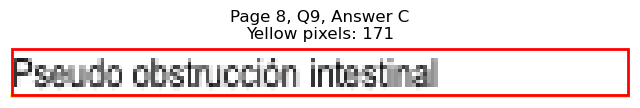

Page 8, Q9 - D: Detected box: x0=327.5, y0=733.2, x1=356.2, y1=745.8
Page 8, Q9, D: Yellow pixels: 919
Page 8, Q9, D: Total non-white pixels: 1040
Page 8, Q9, D: Yellow percentage: 88.4%


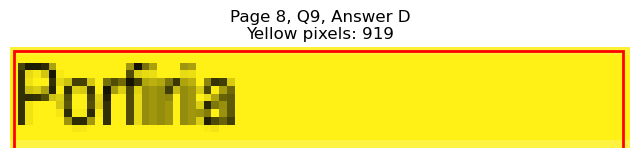


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)





Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=152.1, y1=127.3
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 399
Page 9, Q1, A: Yellow percentage: 0.0%


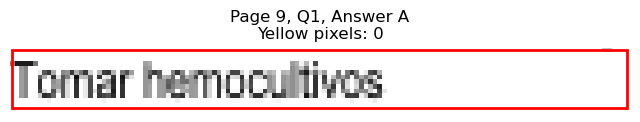

Page 9, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=156.0, y1=139.9
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 424
Page 9, Q1, B: Yellow percentage: 0.0%


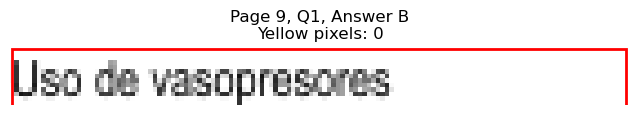

Page 9, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=438.9, y1=127.3
Page 9, Q1, C: Yellow pixels: 162
Page 9, Q1, C: Total non-white pixels: 713
Page 9, Q1, C: Yellow percentage: 22.7%


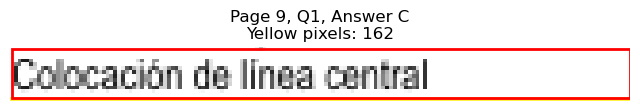

Page 9, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=406.3, y1=139.9
Page 9, Q1, D: Yellow pixels: 1368
Page 9, Q1, D: Total non-white pixels: 1690
Page 9, Q1, D: Yellow percentage: 80.9%


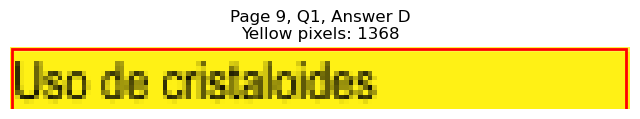


Page 9, Q1 - Selected Answer: D (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=107.4, y1=190.4
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 226
Page 9, Q2, A: Yellow percentage: 0.0%


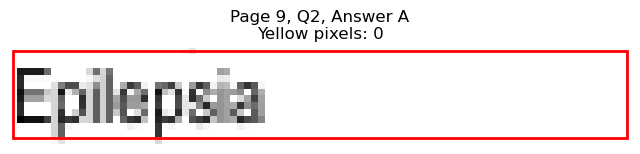

Page 9, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=112.5, y1=203.0
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 233
Page 9, Q2, B: Yellow percentage: 0.0%


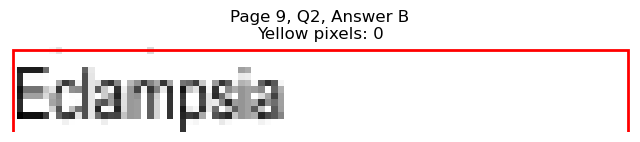

Page 9, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=387.3, y1=190.4
Page 9, Q2, C: Yellow pixels: 111
Page 9, Q2, C: Total non-white pixels: 397
Page 9, Q2, C: Yellow percentage: 28.0%


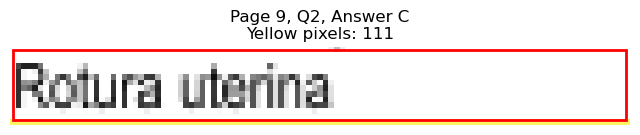

Page 9, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=415.9, y1=203.0
Page 9, Q2, D: Yellow pixels: 1454
Page 9, Q2, D: Total non-white pixels: 1807
Page 9, Q2, D: Yellow percentage: 80.5%


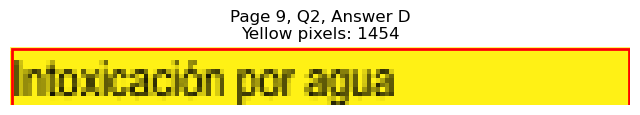


Page 9, Q2 - Selected Answer: D (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=196.7, y1=266.1
Page 9, Q3, A: Yellow pixels: 1864
Page 9, Q3, A: Total non-white pixels: 2506
Page 9, Q3, A: Yellow percentage: 74.4%


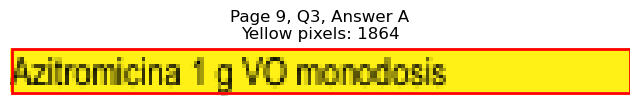

Page 9, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=173.7, y1=278.7
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 670
Page 9, Q3, B: Yellow percentage: 0.0%


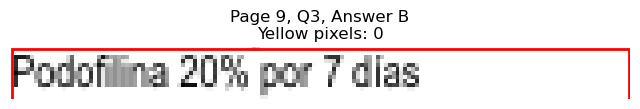

Page 9, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=460.9, y1=266.1
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 632
Page 9, Q3, C: Yellow percentage: 0.0%


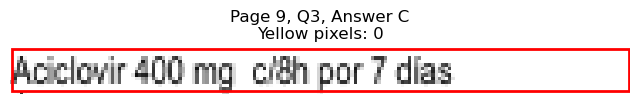

Page 9, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=474.1, y1=278.7
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 735
Page 9, Q3, D: Yellow percentage: 0.0%


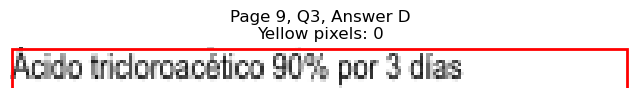


Page 9, Q3 - Selected Answer: A (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=261.9, y1=329.3
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 908
Page 9, Q4, A: Yellow percentage: 0.0%


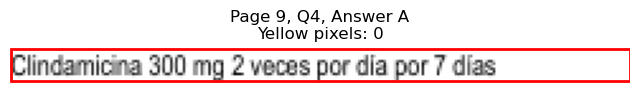

Page 9, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=220.4, y1=341.9
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 736
Page 9, Q4, B: Yellow percentage: 0.0%


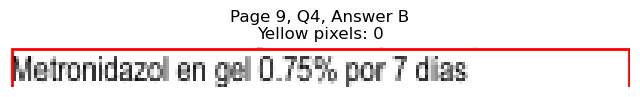

Page 9, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=446.9, y1=329.3
Page 9, Q4, C: Yellow pixels: 1581
Page 9, Q4, C: Total non-white pixels: 2380
Page 9, Q4, C: Yellow percentage: 66.4%


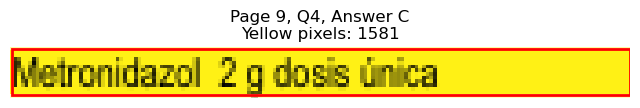

Page 9, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=485.6, y1=341.9
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 993
Page 9, Q4, D: Yellow percentage: 0.0%


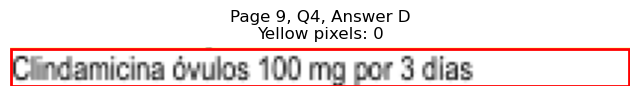


Page 9, Q4 - Selected Answer: C (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=149.1, y1=417.6
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 397
Page 9, Q5, A: Yellow percentage: 0.0%


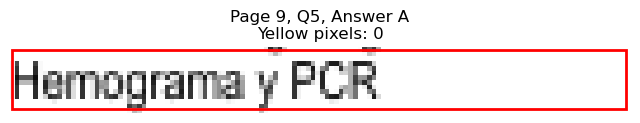

Page 9, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=168.6, y1=430.3
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 538
Page 9, Q5, B: Yellow percentage: 0.0%


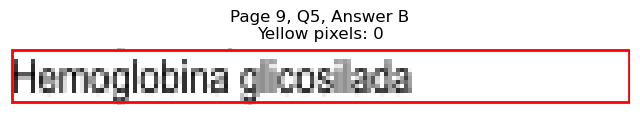

Page 9, Q5 - C: Detected box: x0=327.5, y0=404.9, x1=401.8, y1=417.6
Page 9, Q5, C: Yellow pixels: 1325
Page 9, Q5, C: Total non-white pixels: 1750
Page 9, Q5, C: Yellow percentage: 75.7%


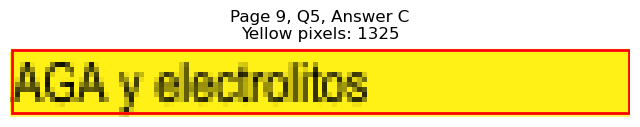

Page 9, Q5 - D: Detected box: x0=327.5, y0=417.6, x1=397.3, y1=430.3
Page 9, Q5, D: Yellow pixels: 121
Page 9, Q5, D: Total non-white pixels: 465
Page 9, Q5, D: Yellow percentage: 26.0%


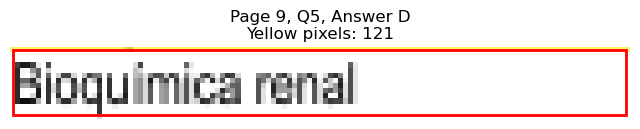


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=493.4, x1=129.0, y1=506.0
Page 9, Q6, A: Yellow pixels: 1240
Page 9, Q6, A: Total non-white pixels: 1456
Page 9, Q6, A: Yellow percentage: 85.2%


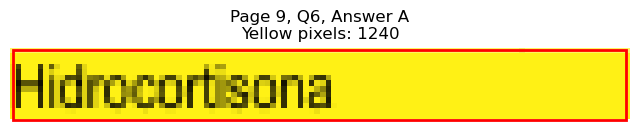

Page 9, Q6 - B: Detected box: x0=68.3, y0=506.0, x1=161.1, y1=518.6
Page 9, Q6, B: Yellow pixels: 144
Page 9, Q6, B: Total non-white pixels: 625
Page 9, Q6, B: Yellow percentage: 23.0%


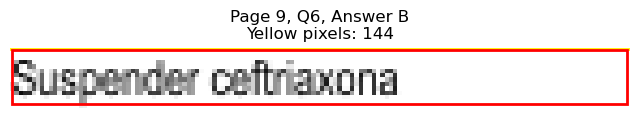

Page 9, Q6 - C: Detected box: x0=327.5, y0=493.4, x1=372.7, y1=506.0
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 250
Page 9, Q6, C: Yellow percentage: 0.0%


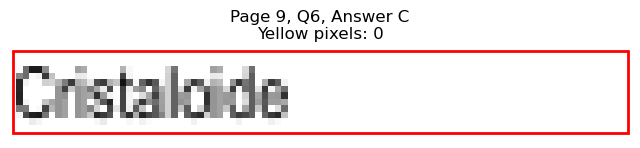

Page 9, Q6 - D: Detected box: x0=327.5, y0=506.0, x1=386.7, y1=518.6
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 320
Page 9, Q6, D: Yellow percentage: 0.0%


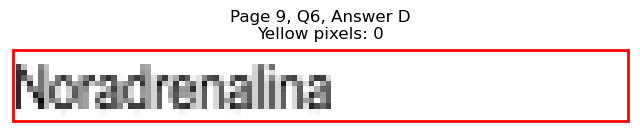


Page 9, Q6 - Selected Answer: A (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=556.5, x1=134.5, y1=569.2
Page 9, Q7, A: Yellow pixels: 1284
Page 9, Q7, A: Total non-white pixels: 1638
Page 9, Q7, A: Yellow percentage: 78.4%


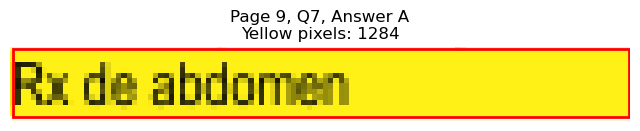

Page 9, Q7 - B: Detected box: x0=68.3, y0=569.1, x1=143.5, y1=581.8
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 480
Page 9, Q7, B: Yellow percentage: 0.0%


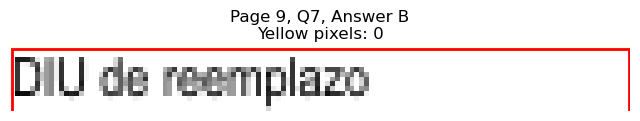

Page 9, Q7 - C: Detected box: x0=327.5, y0=556.5, x1=428.8, y1=569.2
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 506
Page 9, Q7, C: Yellow percentage: 0.0%


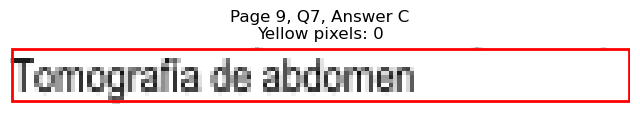

Page 9, Q7 - D: Detected box: x0=327.5, y0=569.1, x1=384.8, y1=581.8
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 277
Page 9, Q7, D: Yellow percentage: 0.0%


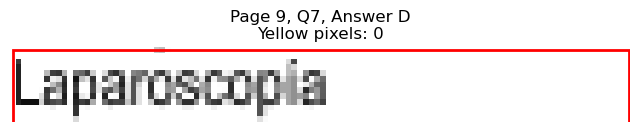


Page 9, Q7 - Selected Answer: A (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=619.6, x1=162.1, y1=632.3
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 488
Page 9, Q8, A: Yellow percentage: 0.0%


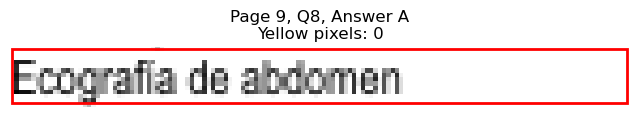

Page 9, Q8 - B: Detected box: x0=68.3, y0=632.2, x1=134.5, y1=644.9
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 308
Page 9, Q8, B: Yellow percentage: 0.0%


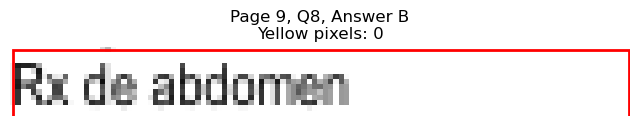

Page 9, Q8 - C: Detected box: x0=327.5, y0=619.6, x1=376.1, y1=632.3
Page 9, Q8, C: Yellow pixels: 1010
Page 9, Q8, C: Total non-white pixels: 1400
Page 9, Q8, C: Yellow percentage: 72.1%


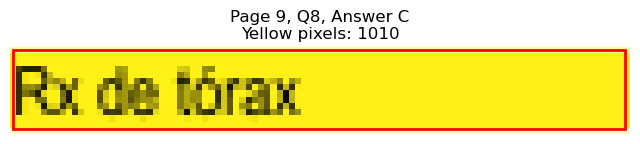

Page 9, Q8 - D: Detected box: x0=327.5, y0=632.2, x1=437.9, y1=644.9
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 733
Page 9, Q8, D: Yellow percentage: 0.0%


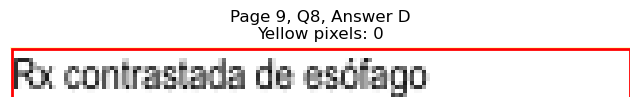


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=695.4, x1=165.6, y1=708.0
Page 9, Q9, A: Yellow pixels: 148
Page 9, Q9, A: Total non-white pixels: 802
Page 9, Q9, A: Yellow percentage: 18.5%


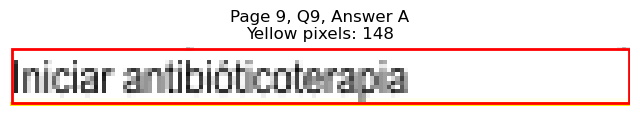

Page 9, Q9 - B: Detected box: x0=68.3, y0=708.0, x1=152.5, y1=720.6
Page 9, Q9, B: Yellow pixels: 1401
Page 9, Q9, B: Total non-white pixels: 1890
Page 9, Q9, B: Yellow percentage: 74.1%


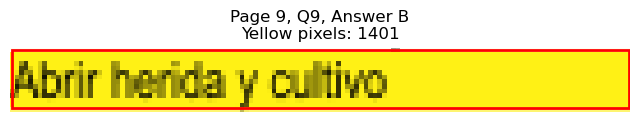

Page 9, Q9 - C: Detected box: x0=327.5, y0=695.4, x1=407.3, y1=708.0
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 402
Page 9, Q9, C: Yellow percentage: 0.0%


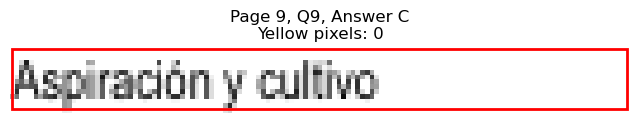

Page 9, Q9 - D: Detected box: x0=327.5, y0=708.0, x1=381.2, y1=720.6
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 293
Page 9, Q9, D: Yellow percentage: 0.0%


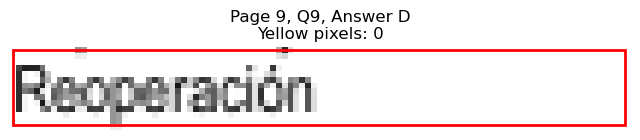


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)





Page 10: Found 10 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=123.6, y1=114.7
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 285
Page 10, Q1, A: Yellow percentage: 0.0%


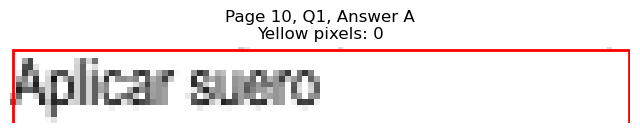

Page 10, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=141.0, y1=127.3
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 339
Page 10, Q1, B: Yellow percentage: 0.0%


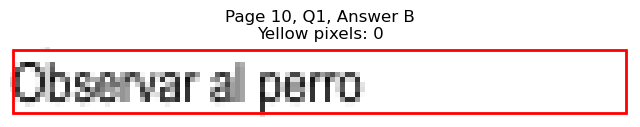

Page 10, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=396.9, y1=114.7
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 469
Page 10, Q1, C: Yellow percentage: 0.0%


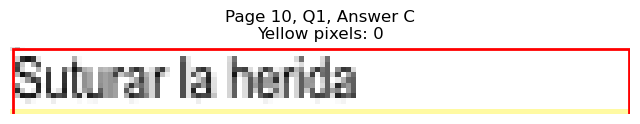

Page 10, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=402.4, y1=127.3
Page 10, Q1, D: Yellow pixels: 1228
Page 10, Q1, D: Total non-white pixels: 1764
Page 10, Q1, D: Yellow percentage: 69.6%


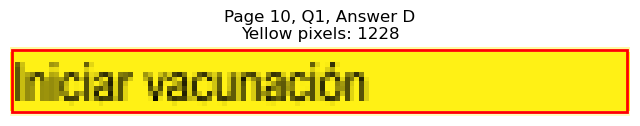


Page 10, Q1 - Selected Answer: D (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=118.5, y1=190.4
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 251
Page 10, Q2, A: Yellow percentage: 0.0%


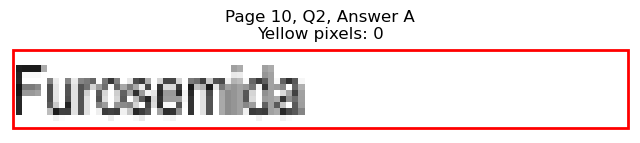

Page 10, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=155.5, y1=203.0
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 462
Page 10, Q2, B: Yellow percentage: 0.0%


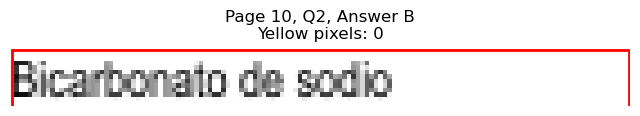

Page 10, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=409.3, y1=190.4
Page 10, Q2, C: Yellow pixels: 1301
Page 10, Q2, C: Total non-white pixels: 1862
Page 10, Q2, C: Yellow percentage: 69.9%


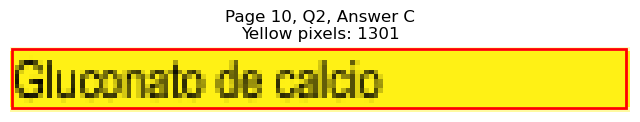

Page 10, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=361.1, y1=203.0
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 263
Page 10, Q2, D: Yellow percentage: 0.0%


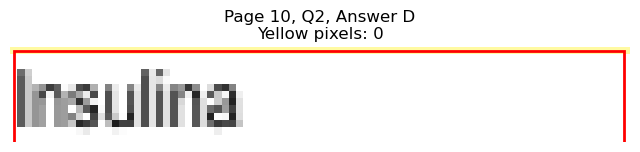


Page 10, Q2 - Selected Answer: C (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=121.9, y1=278.7
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 299
Page 10, Q3, A: Yellow percentage: 0.0%


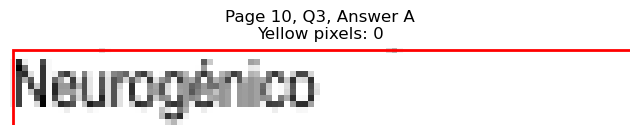

Page 10, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=116.4, y1=291.5
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 238
Page 10, Q3, B: Yellow percentage: 0.0%


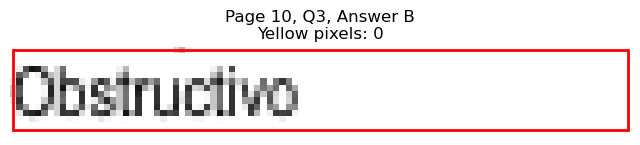

Page 10, Q3 - C: Detected box: x0=327.5, y0=266.1, x1=374.7, y1=278.7
Page 10, Q3, C: Yellow pixels: 1078
Page 10, Q3, C: Total non-white pixels: 1274
Page 10, Q3, C: Yellow percentage: 84.6%


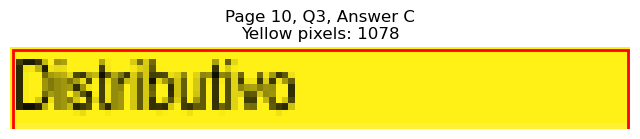

Page 10, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=383.2, y1=291.5
Page 10, Q3, D: Yellow pixels: 107
Page 10, Q3, D: Total non-white pixels: 413
Page 10, Q3, D: Yellow percentage: 25.9%


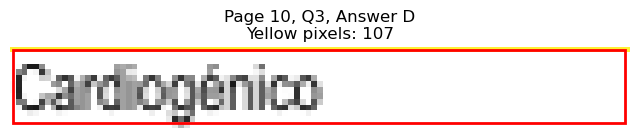


Page 10, Q3 - Selected Answer: C (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=80.9, y1=329.3
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 69
Page 10, Q4, A: Yellow percentage: 0.0%


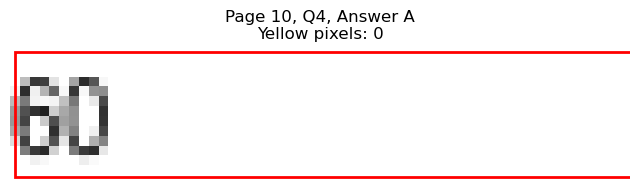

Page 10, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=80.9, y1=341.9
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 67
Page 10, Q4, B: Yellow percentage: 0.0%


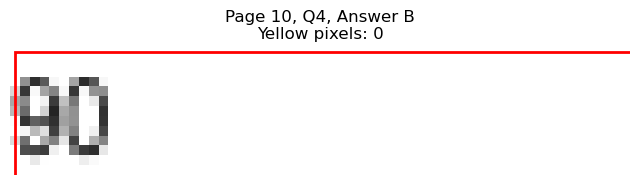

Page 10, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=340.1, y1=329.3
Page 10, Q4, C: Yellow pixels: 729
Page 10, Q4, C: Total non-white pixels: 896
Page 10, Q4, C: Yellow percentage: 81.4%


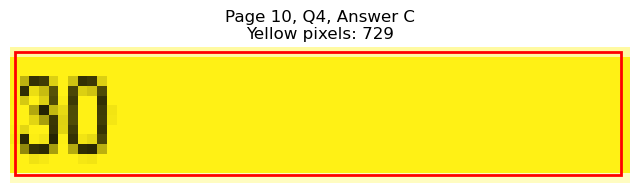

Page 10, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=340.1, y1=341.9
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 108
Page 10, Q4, D: Yellow percentage: 0.0%


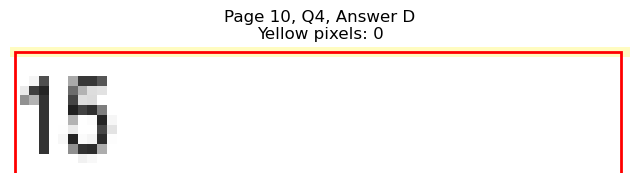


Page 10, Q4 - Selected Answer: C (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=392.3, x1=127.5, y1=405.0
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 425
Page 10, Q5, A: Yellow percentage: 0.0%


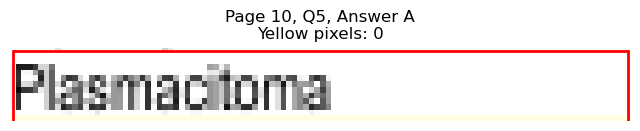

Page 10, Q5 - B: Detected box: x0=68.3, y0=404.9, x1=237.4, y1=417.6
Page 10, Q5, B: Yellow pixels: 2133
Page 10, Q5, B: Total non-white pixels: 2996
Page 10, Q5, B: Yellow percentage: 71.2%


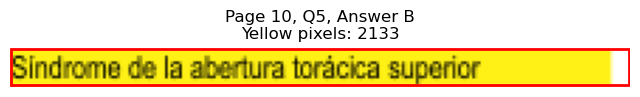

Page 10, Q5 - C: Detected box: x0=327.5, y0=392.3, x1=422.0, y1=405.0
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 486
Page 10, Q5, C: Yellow percentage: 0.0%


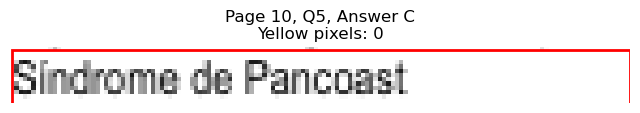

Page 10, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=405.8, y1=417.6
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 390
Page 10, Q5, D: Yellow percentage: 0.0%


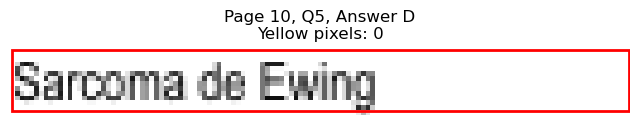


Page 10, Q5 - Selected Answer: B (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=68.3, y0=468.1, x1=145.6, y1=480.7
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 454
Page 10, Q6, A: Yellow percentage: 0.0%


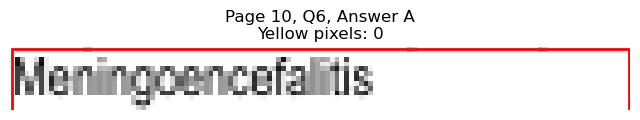

Page 10, Q6 - B: Detected box: x0=68.3, y0=480.8, x1=107.4, y1=493.4
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 227
Page 10, Q6, B: Yellow percentage: 0.0%


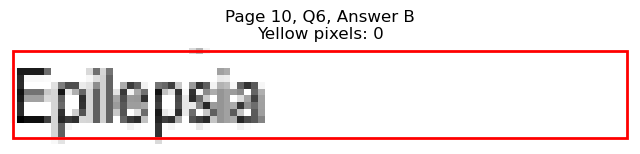

Page 10, Q6 - C: Detected box: x0=327.5, y0=468.1, x1=377.7, y1=480.7
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 264
Page 10, Q6, C: Yellow percentage: 0.0%


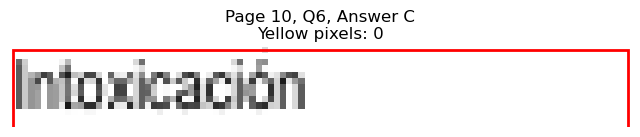

Page 10, Q6 - D: Detected box: x0=327.5, y0=480.8, x1=396.8, y1=493.4
Page 10, Q6, D: Yellow pixels: 1155
Page 10, Q6, D: Total non-white pixels: 1680
Page 10, Q6, D: Yellow percentage: 68.8%


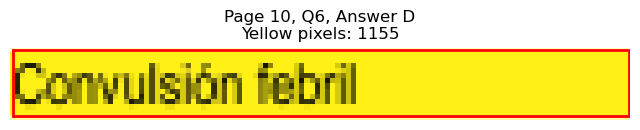


Page 10, Q6 - Selected Answer: D (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=68.3, y0=531.2, x1=148.1, y1=543.8
Page 10, Q7, A: Yellow pixels: 1346
Page 10, Q7, A: Total non-white pixels: 1703
Page 10, Q7, A: Yellow percentage: 79.0%


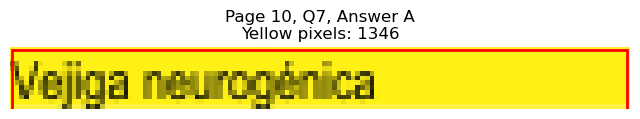

Page 10, Q7 - B: Detected box: x0=68.3, y0=543.8, x1=142.0, y1=556.4
Page 10, Q7, B: Yellow pixels: 114
Page 10, Q7, B: Total non-white pixels: 539
Page 10, Q7, B: Yellow percentage: 21.2%


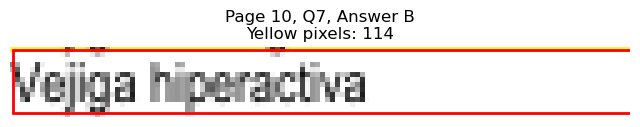

Page 10, Q7 - C: Detected box: x0=327.5, y0=531.2, x1=455.5, y1=543.8
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 664
Page 10, Q7, C: Yellow percentage: 0.0%


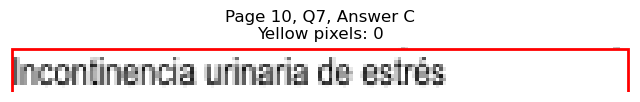

Page 10, Q7 - D: Detected box: x0=327.5, y0=543.8, x1=465.5, y1=556.4
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 692
Page 10, Q7, D: Yellow percentage: 0.0%


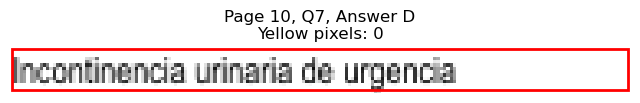


Page 10, Q7 - Selected Answer: A (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=68.3, y0=606.9, x1=134.5, y1=619.6
Page 10, Q8, A: Yellow pixels: 1244
Page 10, Q8, A: Total non-white pixels: 1638
Page 10, Q8, A: Yellow percentage: 75.9%


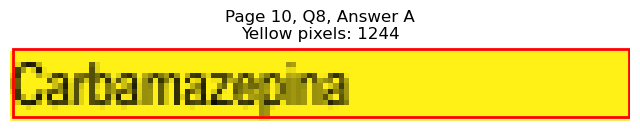

Page 10, Q8 - B: Detected box: x0=68.3, y0=619.6, x1=116.4, y1=632.3
Page 10, Q8, B: Yellow pixels: 99
Page 10, Q8, B: Total non-white pixels: 338
Page 10, Q8, B: Yellow percentage: 29.3%


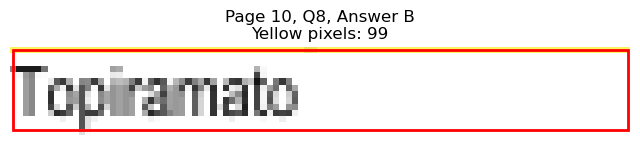

Page 10, Q8 - C: Detected box: x0=327.5, y0=606.9, x1=367.6, y1=619.6
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 201
Page 10, Q8, C: Yellow percentage: 0.0%


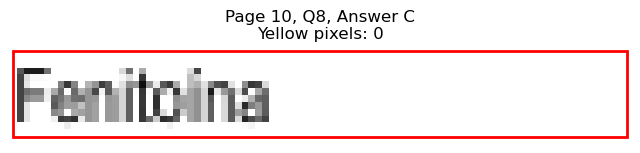

Page 10, Q8 - D: Detected box: x0=327.5, y0=619.6, x1=391.3, y1=632.3
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 324
Page 10, Q8, D: Yellow percentage: 0.0%


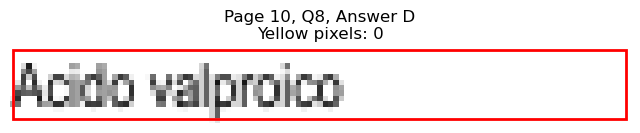


Page 10, Q8 - Selected Answer: A (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=68.3, y0=682.7, x1=151.7, y1=695.3
Page 10, Q9, A: Yellow pixels: 0
Page 10, Q9, A: Total non-white pixels: 402
Page 10, Q9, A: Yellow percentage: 0.0%


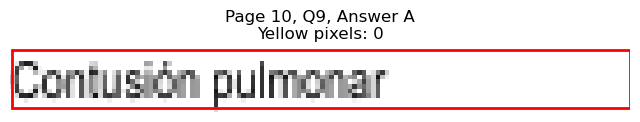

Page 10, Q9 - B: Detected box: x0=68.3, y0=695.4, x1=164.1, y1=708.0
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 486
Page 10, Q9, B: Yellow percentage: 0.0%


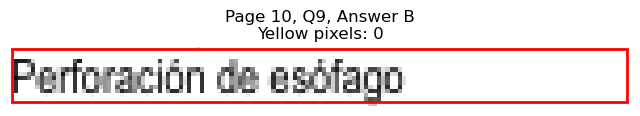

Page 10, Q9 - C: Detected box: x0=327.5, y0=682.7, x1=423.8, y1=695.3
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 505
Page 10, Q9, C: Yellow percentage: 0.0%


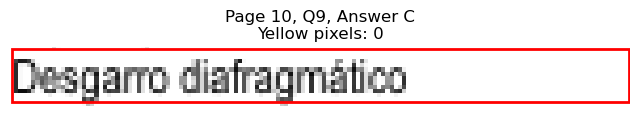

Page 10, Q9 - D: Detected box: x0=327.5, y0=695.4, x1=397.7, y1=708.0
Page 10, Q9, D: Yellow pixels: 1297
Page 10, Q9, D: Total non-white pixels: 1575
Page 10, Q9, D: Yellow percentage: 82.3%


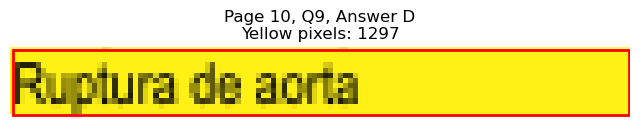


Page 10, Q9 - Selected Answer: D (based on yellow pixel count)




Page 10, Q10 - A: Detected box: x0=68.3, y0=733.2, x1=79.8, y1=745.8
Page 10, Q10, A: Yellow pixels: 0
Page 10, Q10, A: Total non-white pixels: 147
Page 10, Q10, A: Yellow percentage: 0.0%


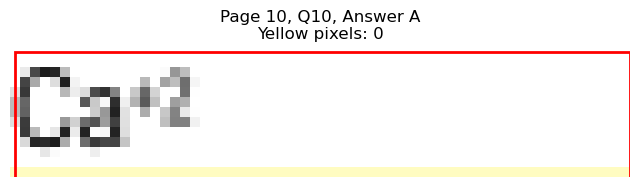

Page 10, Q10 - B: Detected box: x0=83.2, y0=745.8, x1=113.3, y1=758.4
Page 10, Q10, B: Yellow pixels: 953
Page 10, Q10, B: Total non-white pixels: 1134
Page 10, Q10, B: Yellow percentage: 84.0%


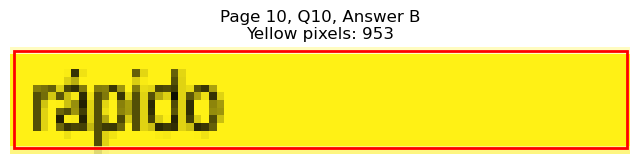

Page 10, Q10 - C: Detected box: x0=336.9, y0=733.2, x1=416.1, y1=745.8
Page 10, Q10, C: Yellow pixels: 0
Page 10, Q10, C: Total non-white pixels: 379
Page 10, Q10, C: Yellow percentage: 0.0%


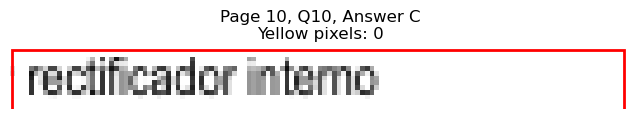

Page 10, Q10 - D: Detected box: x0=336.9, y0=745.8, x1=400.2, y1=758.4
Page 10, Q10, D: Yellow pixels: 0
Page 10, Q10, D: Total non-white pixels: 291
Page 10, Q10, D: Yellow percentage: 0.0%


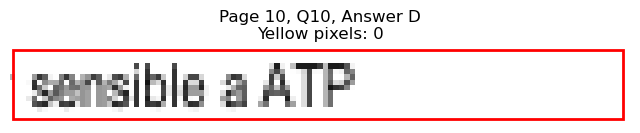


Page 10, Q10 - Selected Answer: B (based on yellow pixel count)





Page 11: Found 7 questions
Page 11, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=123.5, y1=127.3
Page 11, Q1, A: Yellow pixels: 1044
Page 11, Q1, A: Total non-white pixels: 1484
Page 11, Q1, A: Yellow percentage: 70.4%


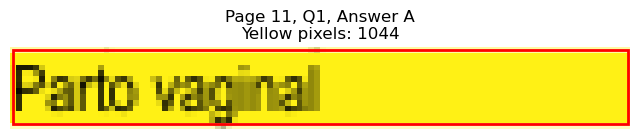

Page 11, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=180.1, y1=139.9
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 709
Page 11, Q1, B: Yellow percentage: 0.0%


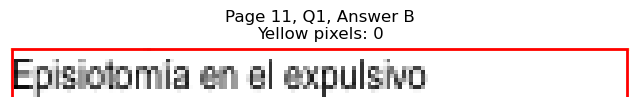

Page 11, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=426.3, y1=127.3
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 508
Page 11, Q1, C: Yellow percentage: 0.0%


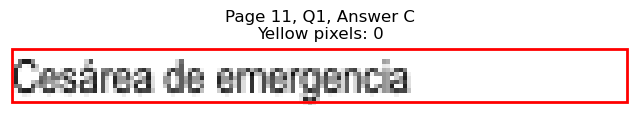

Page 11, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=411.3, y1=139.9
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 413
Page 11, Q1, D: Yellow percentage: 0.0%


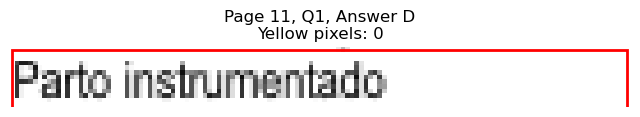


Page 11, Q1 - Selected Answer: A (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=144.0, y1=203.0
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 513
Page 11, Q2, A: Yellow percentage: 0.0%


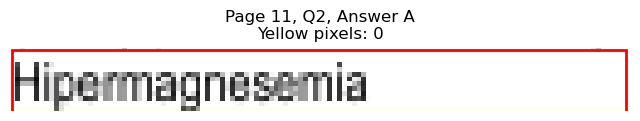

Page 11, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=120.5, y1=215.6
Page 11, Q2, B: Yellow pixels: 1131
Page 11, Q2, B: Total non-white pixels: 1442
Page 11, Q2, B: Yellow percentage: 78.4%


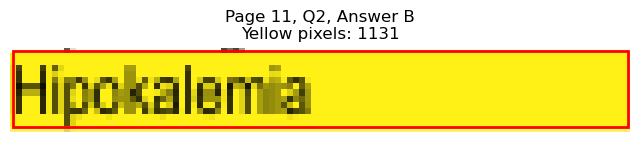

Page 11, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=382.7, y1=203.0
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 301
Page 11, Q2, C: Yellow percentage: 0.0%


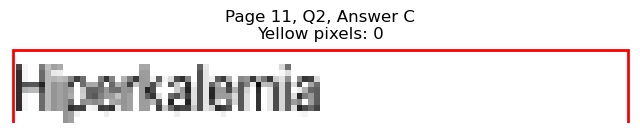

Page 11, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=384.2, y1=215.6
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 312
Page 11, Q2, D: Yellow percentage: 0.0%


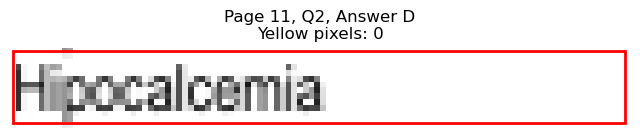


Page 11, Q2 - Selected Answer: B (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=157.1, y1=278.7
Page 11, Q3, A: Yellow pixels: 0
Page 11, Q3, A: Total non-white pixels: 462
Page 11, Q3, A: Yellow percentage: 0.0%


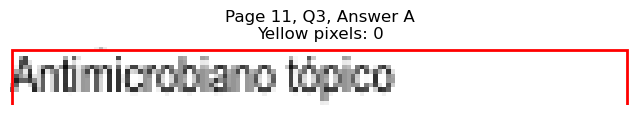

Page 11, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=138.0, y1=291.5
Page 11, Q3, B: Yellow pixels: 0
Page 11, Q3, B: Total non-white pixels: 373
Page 11, Q3, B: Yellow percentage: 0.0%


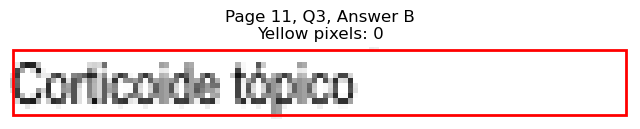

Page 11, Q3 - C: Detected box: x0=327.5, y0=266.1, x1=389.2, y1=278.7
Page 11, Q3, C: Yellow pixels: 1228
Page 11, Q3, C: Total non-white pixels: 1469
Page 11, Q3, C: Yellow percentage: 83.6%


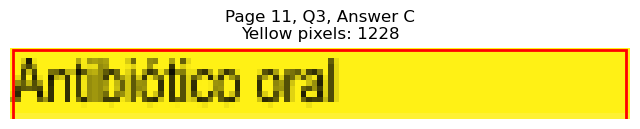

Page 11, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=408.8, y1=291.5
Page 11, Q3, D: Yellow pixels: 132
Page 11, Q3, D: Total non-white pixels: 557
Page 11, Q3, D: Yellow percentage: 23.7%


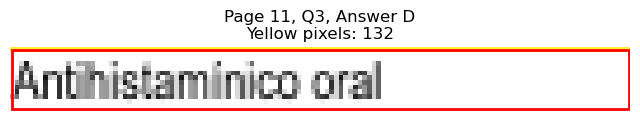


Page 11, Q3 - Selected Answer: C (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=68.3, y0=341.9, x1=158.1, y1=354.6
Page 11, Q4, A: Yellow pixels: 1502
Page 11, Q4, A: Total non-white pixels: 1974
Page 11, Q4, A: Yellow percentage: 76.1%


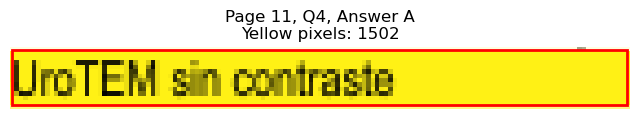

Page 11, Q4 - B: Detected box: x0=68.3, y0=354.5, x1=132.0, y1=367.2
Page 11, Q4, B: Yellow pixels: 115
Page 11, Q4, B: Total non-white pixels: 429
Page 11, Q4, B: Yellow percentage: 26.8%


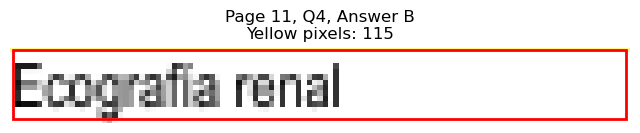

Page 11, Q4 - C: Detected box: x0=327.5, y0=341.9, x1=409.7, y1=354.6
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 430
Page 11, Q4, C: Yellow percentage: 0.0%


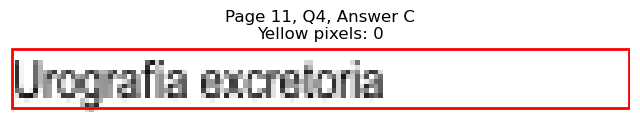

Page 11, Q4 - D: Detected box: x0=327.5, y0=354.5, x1=458.0, y1=367.2
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 696
Page 11, Q4, D: Yellow percentage: 0.0%


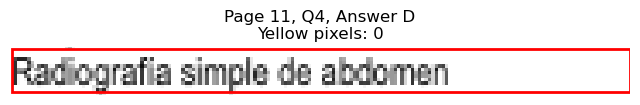


Page 11, Q4 - Selected Answer: A (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=68.3, y0=417.6, x1=130.0, y1=430.3
Page 11, Q5, A: Yellow pixels: 1111
Page 11, Q5, A: Total non-white pixels: 1568
Page 11, Q5, A: Yellow percentage: 70.9%


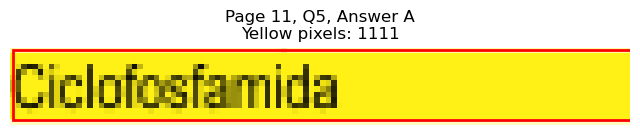

Page 11, Q5 - B: Detected box: x0=68.3, y0=430.2, x1=121.9, y1=442.9
Page 11, Q5, B: Yellow pixels: 0
Page 11, Q5, B: Total non-white pixels: 409
Page 11, Q5, B: Yellow percentage: 0.0%


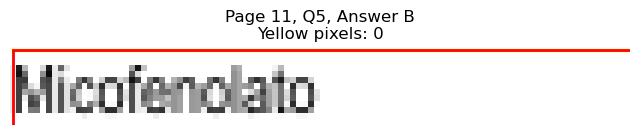

Page 11, Q5 - C: Detected box: x0=327.5, y0=417.6, x1=390.8, y1=430.3
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 317
Page 11, Q5, C: Yellow percentage: 0.0%


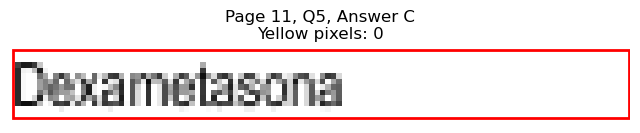

Page 11, Q5 - D: Detected box: x0=327.5, y0=430.2, x1=377.7, y1=442.9
Page 11, Q5, D: Yellow pixels: 0
Page 11, Q5, D: Total non-white pixels: 274
Page 11, Q5, D: Yellow percentage: 0.0%


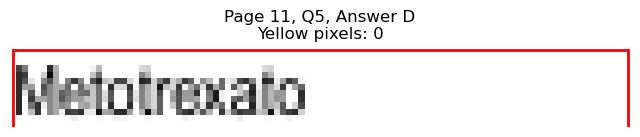


Page 11, Q5 - Selected Answer: A (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=68.3, y0=480.8, x1=171.1, y1=493.4
Page 11, Q6, A: Yellow pixels: 0
Page 11, Q6, A: Total non-white pixels: 492
Page 11, Q6, A: Yellow percentage: 0.0%


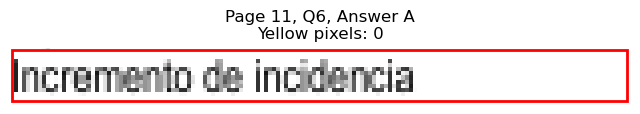

Page 11, Q6 - B: Detected box: x0=68.3, y0=493.4, x1=181.1, y1=506.0
Page 11, Q6, B: Yellow pixels: 0
Page 11, Q6, B: Total non-white pixels: 555
Page 11, Q6, B: Yellow percentage: 0.0%


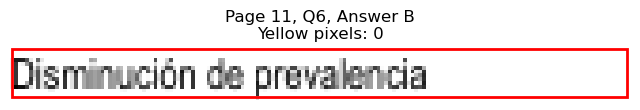

Page 11, Q6 - C: Detected box: x0=327.5, y0=480.8, x1=434.3, y1=493.4
Page 11, Q6, C: Yellow pixels: 158
Page 11, Q6, C: Total non-white pixels: 725
Page 11, Q6, C: Yellow percentage: 21.8%


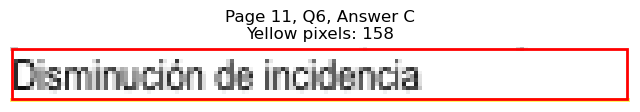

Page 11, Q6 - D: Detected box: x0=327.5, y0=493.4, x1=436.4, y1=506.0
Page 11, Q6, D: Yellow pixels: 1652
Page 11, Q6, D: Total non-white pixels: 2081
Page 11, Q6, D: Yellow percentage: 79.4%


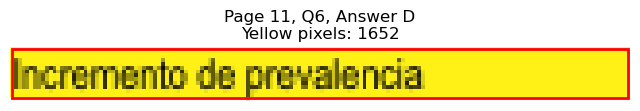


Page 11, Q6 - Selected Answer: D (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=68.3, y0=569.1, x1=200.8, y1=581.8
Page 11, Q7, A: Yellow pixels: 2
Page 11, Q7, A: Total non-white pixels: 859
Page 11, Q7, A: Yellow percentage: 0.2%


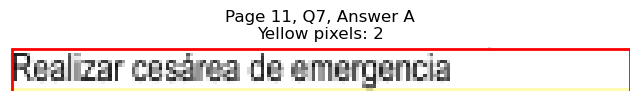

Page 11, Q7 - B: Detected box: x0=68.3, y0=581.7, x1=256.4, y1=594.4
Page 11, Q7, B: Yellow pixels: 1858
Page 11, Q7, B: Total non-white pixels: 2996
Page 11, Q7, B: Yellow percentage: 62.0%


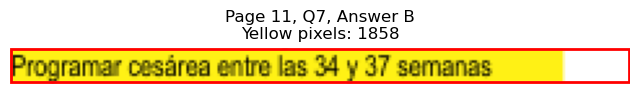

Page 11, Q7 - C: Detected box: x0=327.5, y0=569.1, x1=519.1, y1=581.8
Page 11, Q7, C: Yellow pixels: 0
Page 11, Q7, C: Total non-white pixels: 972
Page 11, Q7, C: Yellow percentage: 0.0%


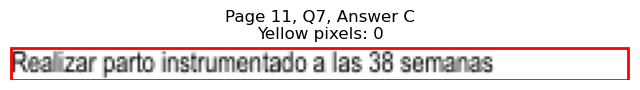

Page 11, Q7 - D: Detected box: x0=327.5, y0=581.7, x1=480.5, y1=594.4
Page 11, Q7, D: Yellow pixels: 0
Page 11, Q7, D: Total non-white pixels: 734
Page 11, Q7, D: Yellow percentage: 0.0%


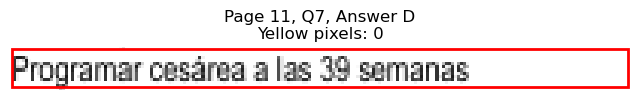


Page 11, Q7 - Selected Answer: B (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Mujer de 45 años, que labora como operaria de ...
1   Mujer de 70 años con diagnóstico de pancreatit...
2   Lactante de 10 meses, irritable, piel con lesi...
3   En la RCP básica de alta calidad del lactante ...
4   Neonato de 5 días, es traído por madre quien r...
..                                                ...
95  Adolescente de 15 años, acude a consultorio po...
96  Varón de 40 años acude por dolor en región lum...
97  Mujer de 36 años con antecedente de LES activo...
98  Se cuenta con un excelente programa de manejo ...
99  Tercigesta de 32 semanas, antecedente de 2 ces...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                           Rótula   
1            Neoplasia pancreática   
2                       Tacrolimus   
3                             30/2   
4              Incompatibilidad Rh   
..                             ...   
95           Antimicrobiano tópico   
96            UroTEM sin contraste   
97                  Ciclofosfamida   
98        Incremento de incidencia   
99  Realizar cesárea de emergencia   

                                       option_B  \
0                                      Meniscos   
1            Acumulación de líquido pancreático   
2                                       Lindano   
3                                          15/2   
4                         Fallo de la lactancia   
..                                          ...   
95                            Corticoide tópico   
96                              Ecografía renal   
97                                 Micofenolato   
98                   Disminución de prevalencia   
99  Programar cesárea entre las 34 y 37 semanas   

                                         option_C  \
0                             Bursa de la rodilla   
1                     Acumulación necrótica aguda   
2                                Permetrina al 5%   
3                                            40/1   
4                                Hepatitis del RN   
..                                            ...   
95                               Antibiótico oral   
96                           Urografía excretoria   
97                                   Dexametasona   
98                      Disminución de incidencia   
99  Realizar parto instrumentado a las 38 semanas   

                              option_D  
0                    Ligamento cruzado  
1              Seudoquiste pancreático  
2                     Mometasona al 1%  
3                                 40/2  
4                       Cefalohematoma  
..                                 ...  
95                Antihistamínico oral  
96       Radiografía simple de abdomen  
97                         Metotrexato  
98           Incremento de prevalencia  
99  Programar cesárea a las 39 semanas  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               C
1               D
2               C
3               A
4               B
..            ...
95              C
96              A
97              A
98              D
99              B

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Mujer de 45 años, que labora como operaria de ...   
1   Mujer de 70 años con diagnóstico de pancreatit...   
2   Lactante de 10 meses, irritable, piel con lesi...   
3   En la RCP básica de alta calidad del lactante ...   
4   Neonato de 5 días, es traído por madre quien r...   
..                                                ...   
95  Adolescente de 15 años, acude a consultorio po...   
96  Varón de 40 años acude por dolor en región lum...   
97  Mujer de 36 años con antecedente de LES activo...   
98  Se cuenta con un excelente programa de manejo ...   
99  Tercigesta de 32 semanas, antecedente de 2 ces...   

                          option_A  \
0                           Rótula   
1            Neoplasia pancreática   
2                       Tacrolimus   
3                             30/2   
4              Incompatibilidad Rh   
..                             ...   
95           Antimicrobiano tópico   
96            UroTEM sin contraste   
97                  Ciclofosfamida   
98        Incremento de incidencia   
99  Realizar cesárea de emergencia   

                                       option_B  \
0                                      Meniscos   
1            Acumulación de líquido pancreático   
2                                       Lindano   
3                                          15/2   
4                         Fallo de la lactancia   
..                                          ...   
95                            Corticoide tópico   
96                              Ecografía renal   
97                                 Micofenolato   
98                   Disminución de prevalencia   
99  Programar cesárea entre las 34 y 37 semanas   

                                         option_C  \
0                             Bursa de la rodilla   
1                     Acumulación necrótica aguda   
2                                Permetrina al 5%   
3                                            40/1   
4                                Hepatitis del RN   
..                                            ...   
95                               Antibiótico oral   
96                           Urografía excretoria   
97                                   Dexametasona   
98                      Disminución de incidencia   
99  Realizar parto instrumentado a las 38 semanas   

                              option_D correct_answer  
0                    Ligamento cruzado              C  
1              Seudoquiste pancreático              D  
2                     Mometasona al 1%              C  
3                                 40/2              A  
4                       Cefalohematoma              B  
..                                 ...            ...  
95                Antihistamínico oral              C  
96       Radiografía simple de abdomen              A  
97                         Metotrexato              A  
98           Incremento de prevalencia              D  
99  Programar cesárea a las 39 semanas              B  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/ESPECIALIADAD B.csv
